# Preventing Hospitalizations with Machine Learning

Author: Lili Beit


![image of computer digits in a heart shape](images/alexander-sinn-KgLtFCgfC28-unsplash-2.png)
  Photo by <a href="https://unsplash.com/@swimstaralex?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Alexander Sinn</a> on <a href="https://unsplash.com/s/photos/machine-learning?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

## Overview

Over the past two decades, the U.S. health care community has taken significant strides in the direction of [value-based care](https://catalyst.nejm.org/doi/full/10.1056/CAT.17.0558).  The federal government and private insurers have started to incentivize providers to deliver high-quality care at low cost, rather than on a fee-for-service basis.  Networks of providers and hospitals that coordinate care are able to improve health outcomes and reduce health care costs.  Under value-based payment systems such as [Medicare's Accountable Care Organization (ACO) program](https://innovation.cms.gov/innovation-models/aco), provider networks that reduce costs are entitled to a share of the savings to the insurer.

## Business Problem

One of the greatest benefits of coordinated care is a reduction in hospitalizations due to better management of chronic diseases. Successfully preventing adverse events helps patients stay healthy, reduces the costs to society of unexpected illness, and creates savings for insurers and ACOs.

Thus, a major goal for ACOs is to identify patients who are at high risk for hospitalization and target them for outreach. By keeping these patients out of the hospital, the ACO can realize its goal of reducing costs to the insurer and keep a share of the savings.

This project uses machine learning to predict which patients are likely to be hospitalized over the next twelve months.  Using the data in their electronic health records (EHR) and billing systems, ACOs can replicate this model to target patients for care management and reduce hospitalizations.

## Data Understanding

To test models for predicting hospitalizations, I used data from the [2017-2018 National Health and Nutrition Examination Survey (NHANES)](https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?BeginYear=2017).  This survey, which is sponsored by the Centers for Disease Control, examined a nationally representative sample of over 9,000 people located in counties across the U.S.  NHANES employs a rigorous process to gather demographic, health history, physical examination, and laboratory data from each participant.  For this project I used only a few of the hundreds of variables NHANES makes publicly available.

For the target, I used the variable showing whether participants had been hospitalized over the past 12 months.  However, I altered this variable to show no hospitalizations for patients whose only hospitalization was for childbirth.

As predictors, I used medical conditions that participants had prior to 12 months ago, as well as medications they had been taking for more than a year. I chose which variables to test based on [Agency for Healthcare Research and Quality (AHRQ) statistics](https://www.hcup-us.ahrq.gov/faststats/NationalDiagnosesServlet) showing the most common hospital diagnoses, as well as a recent [American Journal of Managed Care (AJMC) article](https://www.ajmc.com/view/predicting-hospitalizations-from-electronic-health-record-data) whose authors also developed a predictive model for hospitalizations.

Only 8.5% of NHANES participants were hospitalized, reflecting a large class imbalance between hospitalized and non-hospitalized patients.


## Data Preparation

Most of the data manipulation for this project involved altering the medical conditions data to show only those conditions which patients had had for 12 months or more.  Since the target is hospitalizations within the past year, I only used medical conditions as predictors if patients were diagnosed with them prior to one year ago.  

The one exception to this rule was Chronic Obstructive Pulmonary Disease (COPD).  NHANES did not include a variable asking when the participant was diagnosed with COPD, unlike for the other medical conditions.  The only variable available asked if patients had ever had COPD.  Since COPD is an important predictor of hospitalizations, I included it in the model even though it is possible some patients were diagnosed within the past year.

In a handful of cases, participants did not know how old they were when diagnosed with particular conditions, and instead of an age value, there was a dummy value in the data.  I replaced all dummy values with the median value for that column, with the result that when participants did not know their age of diagnosis, I marked them as having the condition for more than 1 year.

One quirk of NHANES data is that all ages over 80 are top-coded at 80, including ages of diagnosis.  Thus, for patients 80 and older who were also diagnosed with conditions at 80 or above, it is impossible to tell whether they had these conditions for longer than 1 year.  I decided to include these conditions as predictors even though it is not possible to tell whether participants had them before they were hospitalized.

Finally, I excluded participants younger than 2 from this analysis, because the predictors I focused on were not available for these participants.

The data cleaning and feature engineering steps I followed can be found in [this notebook](https://github.com/lilisbeit/nhanes/blob/main/data-cleaning-and-feature_engineering.ipynb).

Before modeling, I set aside 10% of the data in a holdout set, and used it to evaluate the final model.

## Modeling

### Model Types and Metrics

I tested several model types including logistic regression, naive Bayes, random forest, and gradient-boosted tree.  I evaluated each model on its recall (sensitivity) score, while ensuring that the precision (specificity) score was not too low.  Since ACOs will need a list of specific patients to target, the goal of this project was to correctly identify as many hospitalized patients as possible, with a lesser focus on excluding patients who were not hospitalized.  Since reaching high-risk patients is the primary goal, and outreach will benefit all patients, it pays to have more false positives than false negatives.  I set a minimum threshold of 0.2 for precision, meaning that the ratio of false positive to true positives cannot exceed 4:1.  

I also calculated the Receiver Operating Curve (ROC-AUC) score for reference, because the [AJMC article](https://www.ajmc.com/view/predicting-hospitalizations-from-electronic-health-record-data) referenced above used this metric to evaluate models.  The study authors used EHR and billing data to predict which patients would be hospitalized over the next 6 months, and built a model with an ROC-AUC score of 0.846.

All scores were calculated by running five-fold cross-validation and taking the mean of each metric.

### Baseline Model

The baseline model is a logistic regression with a **recall score of 0.02, a precision score of 0.45, and a ROC-AUC score of 0.51**.  Although precision is high, recall is too low to be useful to an ACO.  They would have very few patients on their list to target for outreach.

### Final Model

The final model is a logistic regression with a **recall score of 0.69, a precision score of 0.21 and an ROC-AUC score of 0.74**, when tested on a hold-out set.  This model narrowly beat out a random forest model which had a higher recall of 0.70, but a lower precision of 0.18, below the threshold of 0.2.  The final model included the following features:

* circulatory conditions
* respiratory conditions
* diabetes
* arthritis
* liver conditions
* cancer
* age
* race
* total number of prescription drugs

In [1]:
# import libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import utils as ut

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_colwidth', 1000)

### Feature Selection for Baseline Model

In the baseline model, I included some of the medical conditions most likely to lead to hospitalization, according to the [AHRQ](https://www.hcup-us.ahrq.gov/faststats/NationalDiagnosesServlet) and the [AJMC article](https://www.ajmc.com/view/predicting-hospitalizations-from-electronic-health-record-data):


* circulatory system (in particular heart failure)
* respiratory system (in particular COPD)
* diabetes
* osteoarthritis
* age

Since there are only 9,000 rows in my data, I chose to include around 10 variables as a first pass, since more may make the model's predictions ungeneralizable due to the curse of dimensionality.

Other medical conditions linked to hospitalizations include:
* liver conditions (included later)
* sickle cell anemia (not in NHANES data)
* osteoporosis / hip fractures (add in a future iteration of this project)
* alcohol-related disorders (add in a future iteration of this project)
* depressive disorders (add in a future iteration of this project)

In this model, the variables are continuous, showing how many years the participant has had each medical condition

In [2]:
# import df with continuous variables

yrs_df_3 = pd.read_csv('data/yrs_df').set_index('SEQN')
yrs_df_3


RIDAGEYR  yrs_osteoarth  yrs_other_arth  yrs_heart_fail  \
SEQN                                                                    
93703.00000    2.00000        0.00000         0.00000         0.00000   
93704.00000    2.00000        0.00000         0.00000         0.00000   
93705.00000   66.00000        0.00000         2.00000         0.00000   
93706.00000   18.00000        0.00000         0.00000         0.00000   
93707.00000   13.00000        0.00000         0.00000         0.00000   
...                ...            ...             ...             ...   
102952.00000  70.00000        0.00000         0.00000         0.00000   
102953.00000  42.00000        0.00000         0.00000         0.00000   
102954.00000  41.00000        0.00000         0.00000         0.00000   
102955.00000  14.00000        0.00000         0.00000         0.00000   
102956.00000  38.00000       11.00000         0.00000         0.00000   

              yrs_heart_cond  ever_had_COPD  yrs_emphysema  yrs_chron_bronc  \
SEQN                                                                          
93703.00000          0.00000        0.00000        0.00000          0.00000   
93704.00000          0.00000        0.00000        0.00000          0.00000   
93705.00000          0.00000        0.00000        0.00000          0.00000   
93706.00000          0.00000        0.00000        0.00000          0.00000   
93707.00000          0.00000        0.00000        0.00000          0.00000   
...                      ...            ...            ...              ...   
102952.00000         0.00000        0.00000        0.00000          0.00000   
102953.00000         0.00000        0.00000        0.00000          0.00000   
102954.00000         0.00000        0.00000        0.00000          0.00000   
102955.00000         0.00000        0.00000        0.00000          0.00000   
102956.00000         0.00000        0.00000        0.00000          0.00000   

              yrs_asthma  yrs_diabetes  yrs_taking_ins  HUQ071  
SEQN                                                            
93703.00000      0.00000       0.00000         0.00000 0.00000  
93704.00000      0.00000       0.00000         0.00000 0.00000  
93705.00000      0.00000       0.00000         0.00000 0.00000  
93706.00000      0.00000       0.00000         0.00000 0.00000  
93707.00000      0.00000       0.00000         0.00000 0.00000  
...                  ...           ...             ...     ...  
102952.00000     0.00000       0.00000         0.00000 0.00000  
102953.00000     0.00000       0.00000         0.00000 0.00000  
102954.00000     0.00000       0.00000         0.00000 0.00000  
102955.00000     0.00000       0.00000         0.00000 0.00000  
102956.00000     0.00000       0.00000         0.00000 0.00000  

[8894 rows x 12 columns]

In [3]:
# minority class is just 8.5 %

yrs_df_3['HUQ071'].value_counts(normalize=True)


0.00000   0.91455
1.00000   0.08545
Name: HUQ071, dtype: float64

In [4]:
# create df to plot doughnut chart

target_ratio = pd.DataFrame(yrs_df_3['HUQ071'].value_counts(normalize=True))
target_ratio.rename(index = {0.00000: 'No', 1.00000: 'Yes'}, inplace=True)
target_ratio


HUQ071
No  0.91455
Yes 0.08545

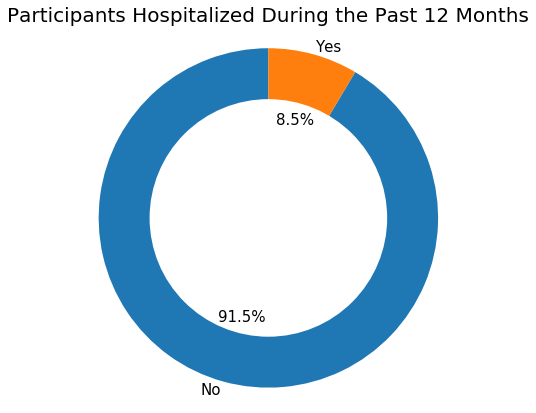

In [5]:
# plot doughnut chart to show target distribution
# minority class is very small

plt.rcParams['font.size'] = 15

fig1, ax1 = plt.subplots(figsize=(8,6))
ax1.pie(target_ratio['HUQ071'], 
        labels=target_ratio.index,
        autopct='%1.1f%%',
        labeldistance=1.05,
        startangle=90,
        textprops = {"fontsize":15})
ax1.set_title('Participants Hospitalized During the Past 12 Months', pad=10, fontsize=20)

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.savefig('images/label-distribution-pie-1', bbox_inches='tight')


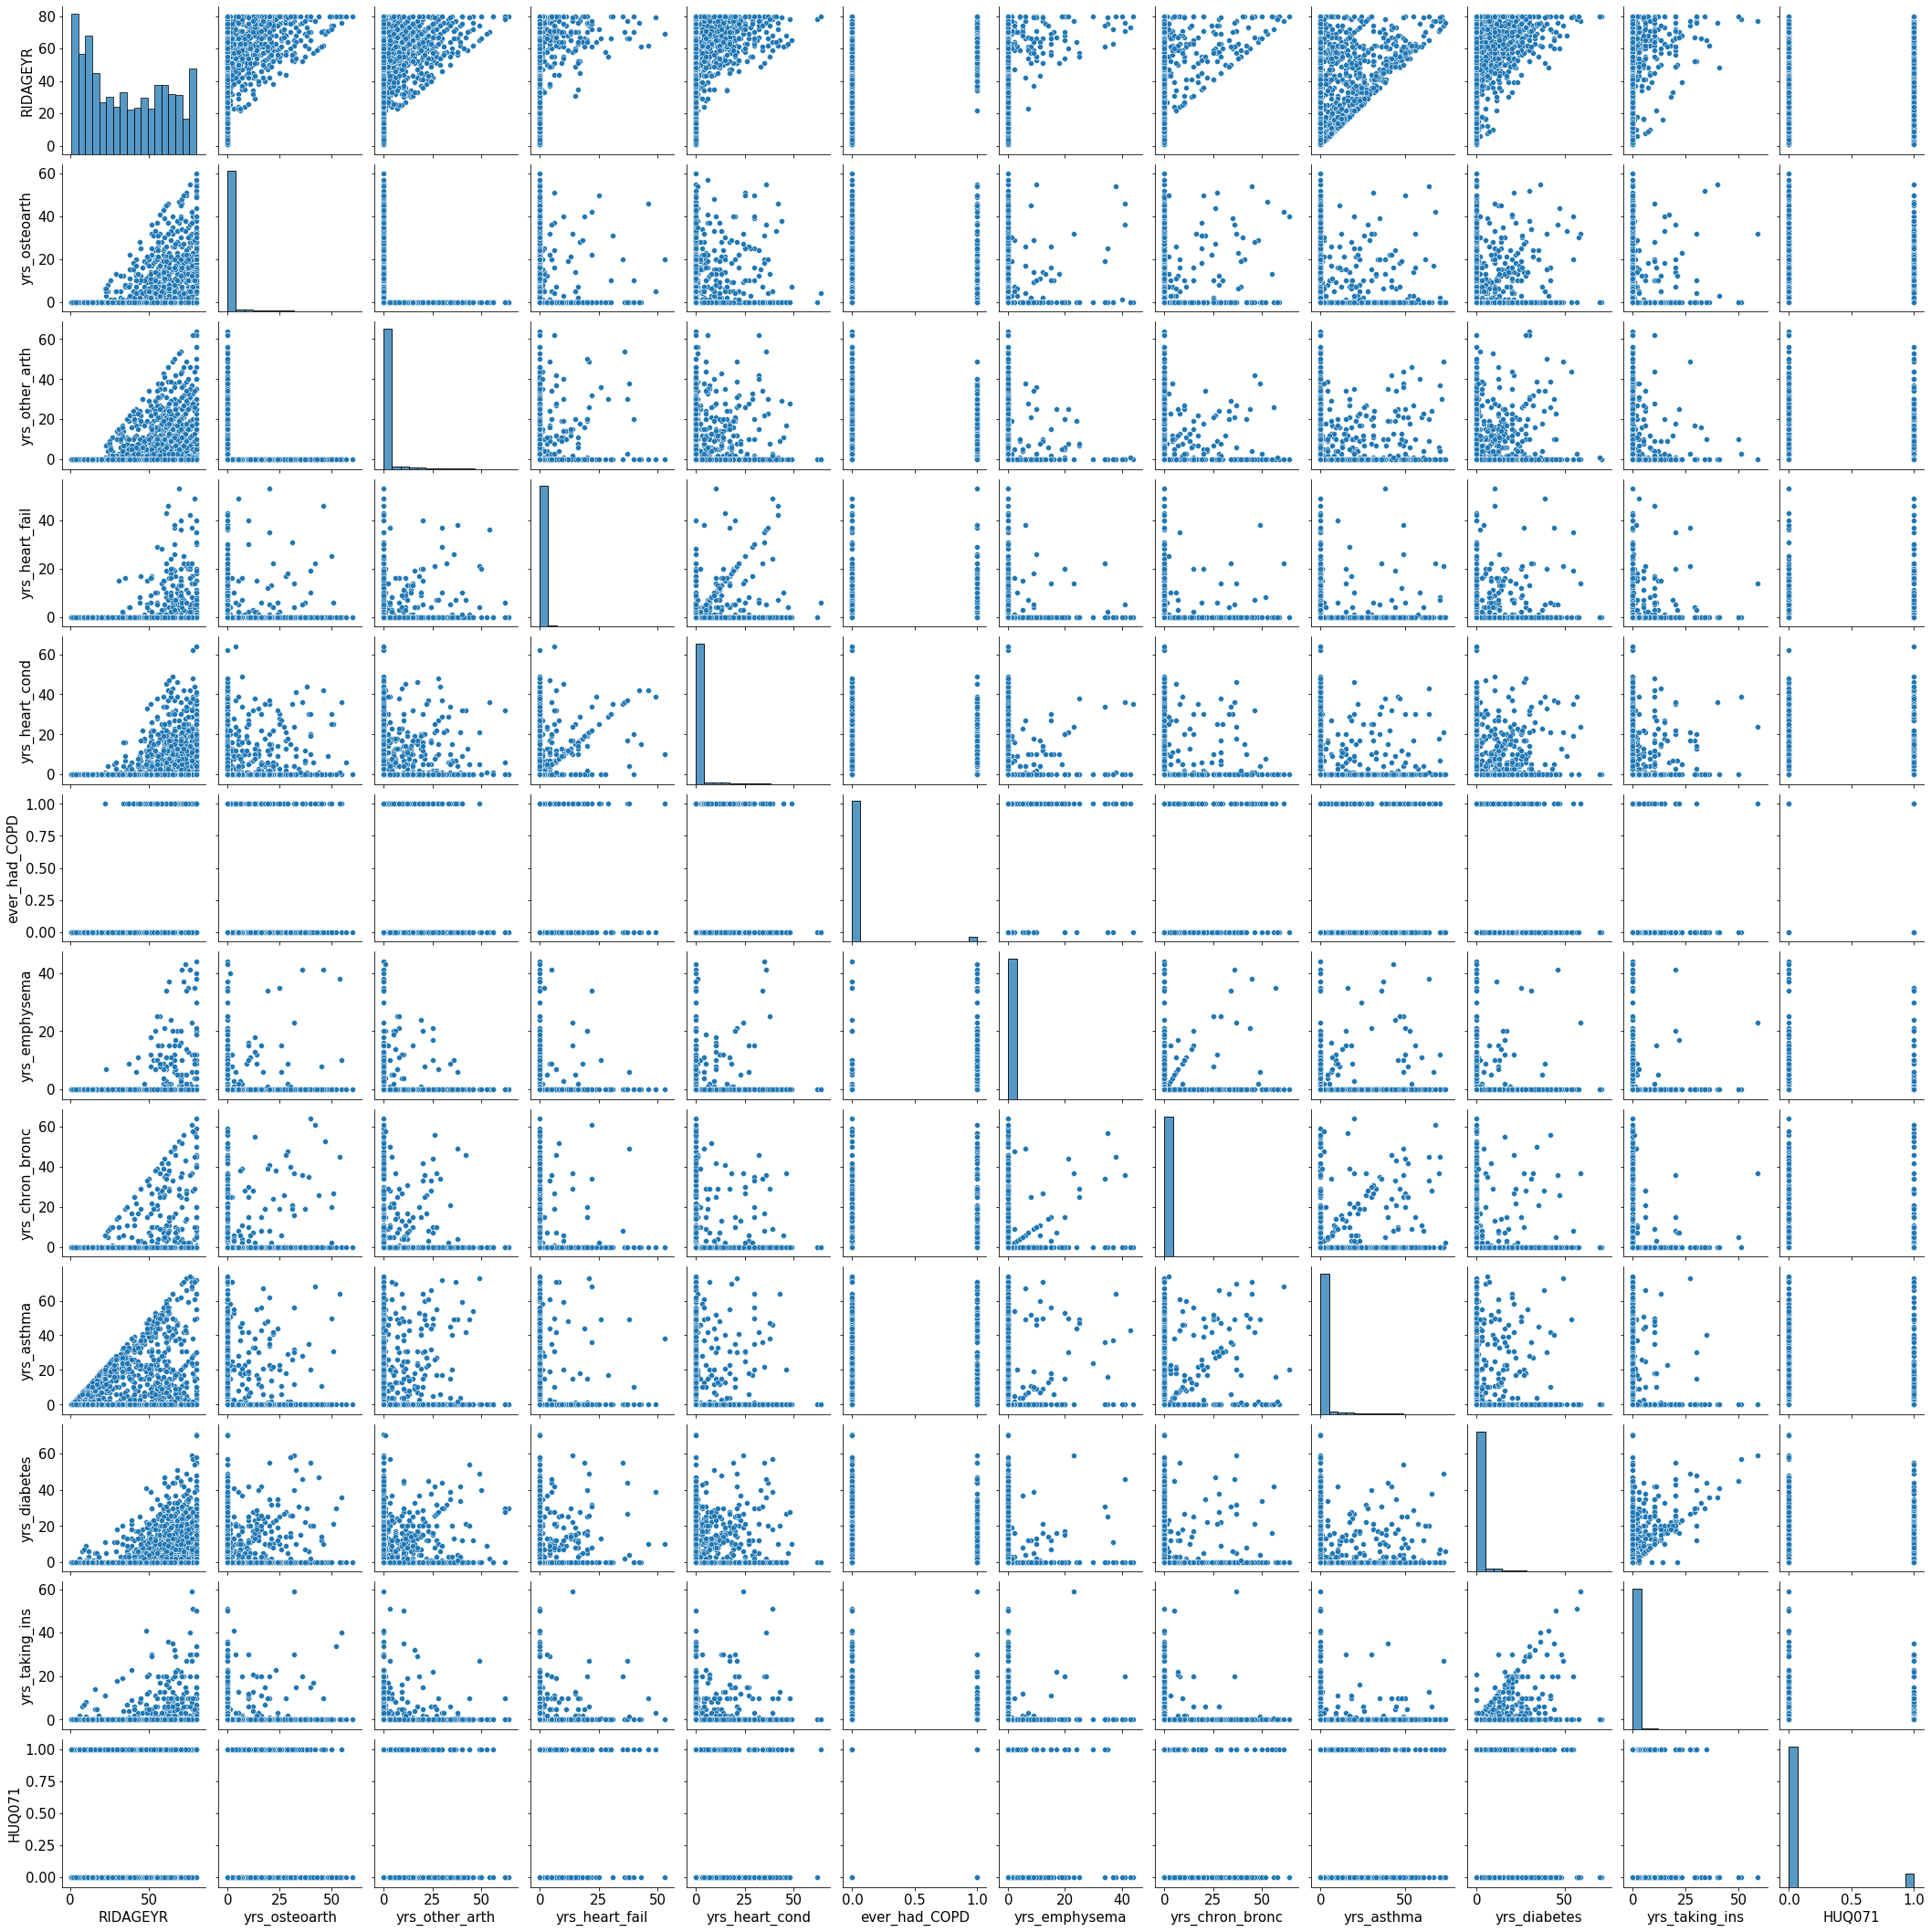

In [6]:
# check correlations between variables

sns.pairplot(yrs_df_3)


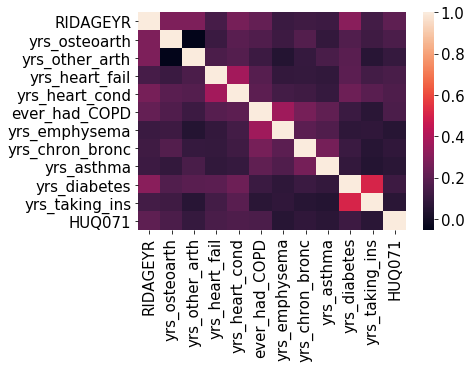

In [7]:
# check correlations with heatmap

corr = yrs_df_3.corr()
sns.heatmap(corr)

# no strong correlations
# even diabetes and taking insulin is only 50% correlated
# nothing is strongly correlated with hospitalization (HUQ071)


### Baseline Model: Logistic regression using continuous variables

In [8]:
# define X and y

X = yrs_df_3.drop(columns = ['HUQ071'])
y = yrs_df_3['HUQ071']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.1, random_state=807)


Classifier: LogisticRegression(max_iter=10000)
Cross-validation folds: 5


Train mean recall: 0.03 +/- 0.01
Train mean precision: 0.59 +/- 0.07
Train mean ROC-AUC: 0.51 +/- 0.0


Test mean recall: 0.02 +/- 0.01
Test mean precision: 0.45 +/- 0.18
Test mean ROC-AUC: 0.51 +/- 0.01


Feature weights: 
                   weight  abs_weight
RIDAGEYR         1.67940     1.67940
yrs_heart_fail   1.61490     1.61490
yrs_heart_cond   1.60670     1.60670
yrs_osteoarth    1.48310     1.48310
yrs_other_arth   0.98410     0.98410
ever_had_COPD    0.71110     0.71110
yrs_taking_ins   0.66050     0.66050
yrs_chron_bronc  0.21340     0.21340
yrs_emphysema   -0.10480     0.10480
yrs_asthma       0.08680     0.08680
yrs_diabetes     0.06540     0.06540 

Confusion matrices for each fold test set: 



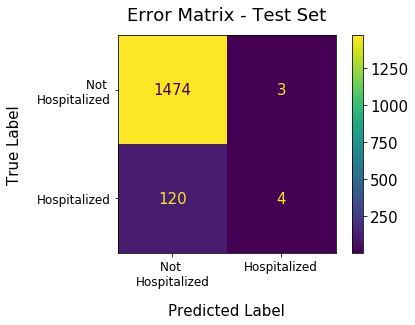

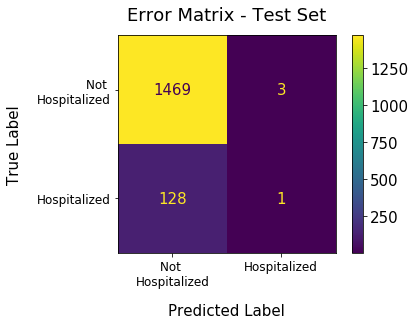

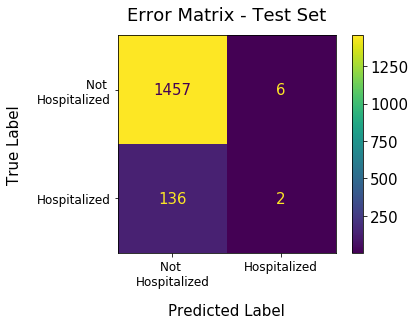

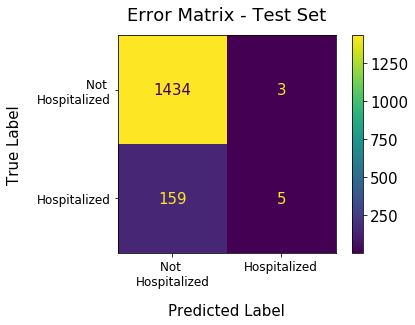

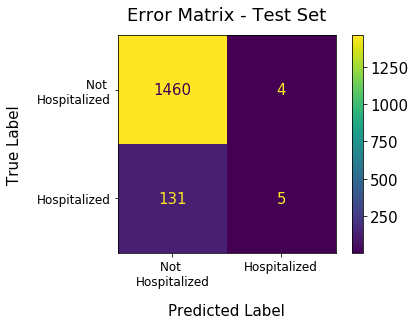

In [9]:
# start with basic logistic regression model
# recall way too low to be useful
# overfit

logreg = LogisticRegression(max_iter=10000)

ut.k_fold_validator(X=X_training, y=y_training, classifier=logreg, cv=5)


### Model 2: Logistic regression using continuous variables and balanced class weights

Classifier: LogisticRegression(class_weight='balanced', max_iter=10000)
Cross-validation folds: 5


Train mean recall: 0.62 +/- 0.01
Train mean precision: 0.16 +/- 0.01
Train mean ROC-AUC: 0.66 +/- 0.01


Test mean recall: 0.62 +/- 0.04
Test mean precision: 0.16 +/- 0.02
Test mean ROC-AUC: 0.65 +/- 0.02


Feature weights: 
                  weight  abs_weight
yrs_heart_cond  2.04340     2.04340
yrs_heart_fail  1.97430     1.97430
yrs_osteoarth   1.88470     1.88470
RIDAGEYR        1.60610     1.60610
yrs_other_arth  1.08130     1.08130
yrs_taking_ins  0.83050     0.83050
ever_had_COPD   0.70650     0.70650
yrs_chron_bronc 0.29250     0.29250
yrs_diabetes    0.15130     0.15130
yrs_asthma      0.09120     0.09120
yrs_emphysema   0.01730     0.01730 

Confusion matrices for each fold test set: 



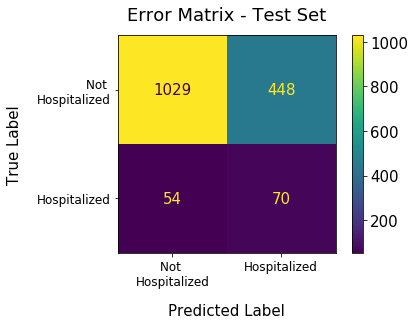

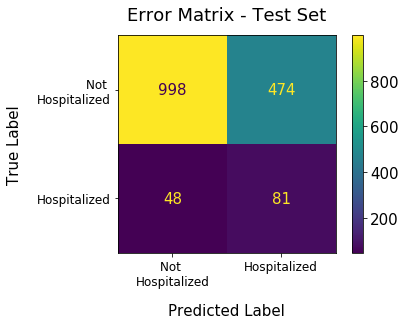

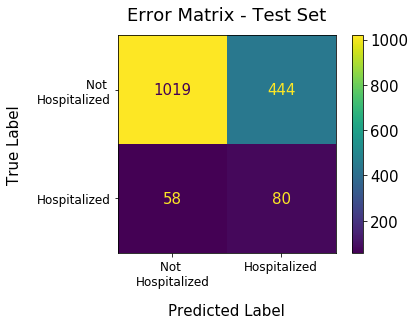

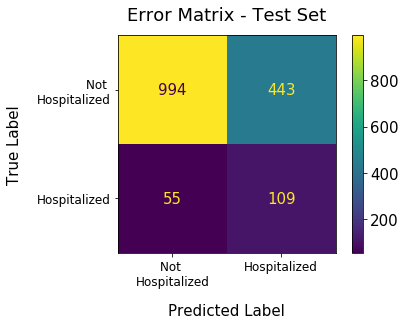

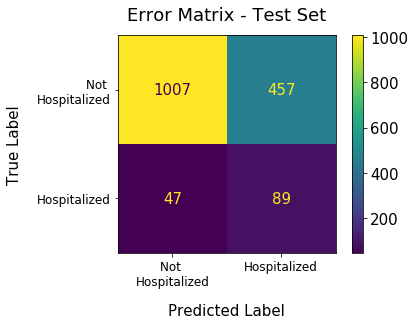

In [10]:
# big improvement over logistic regression without balanced class weight
# better recall, and less overfit
# precision does not pass 0.2 threshold

logreg = LogisticRegression(max_iter=10000, class_weight='balanced')

ut.k_fold_validator(X=X_training, y=y_training, classifier=logreg, cv=5)

### Model 3: Complement Naive Bayes model with continuous variables

Classifier: ComplementNB()
Cross-validation folds: 5


Train mean recall: 0.3 +/- 0.01
Train mean precision: 0.28 +/- 0.0
Train mean ROC-AUC: 0.61 +/- 0.0


Test mean recall: 0.3 +/- 0.01
Test mean precision: 0.27 +/- 0.02
Test mean ROC-AUC: 0.61 +/- 0.01


Feature weights: 
                  weight  abs_weight
yrs_emphysema   5.41350     5.41350
yrs_heart_fail  5.38400     5.38400
yrs_taking_ins  4.96720     4.96720
yrs_chron_bronc 4.68530     4.68530
yrs_heart_cond  3.95170     3.95170
yrs_osteoarth   3.58130     3.58130
yrs_diabetes    3.49430     3.49430
yrs_other_arth  3.48160     3.48160
yrs_asthma      3.29190     3.29190
ever_had_COPD   3.06700     3.06700
RIDAGEYR        0.24480     0.24480 

Confusion matrices for each fold test set: 



/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


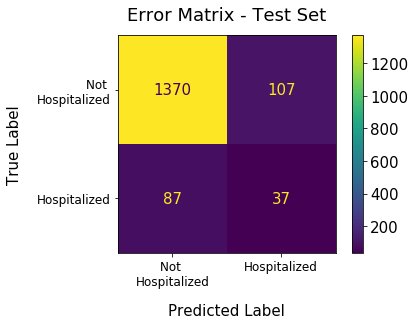

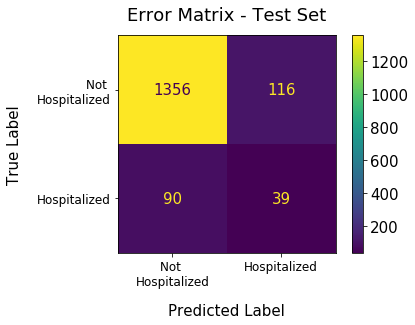

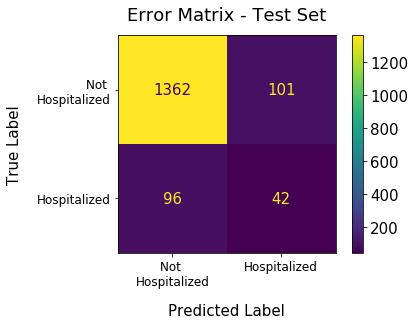

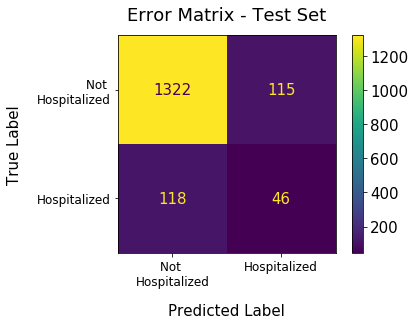

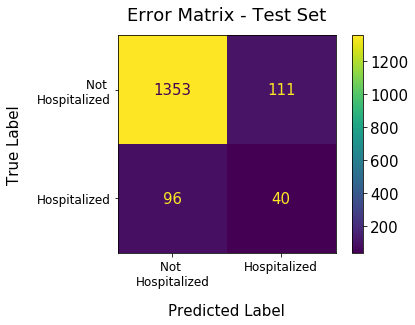

In [11]:
# test a complement Naive Bayes
# recall is worse than Model 2, but precision is above 0.2 threshold

CompNB = ComplementNB()

ut.k_fold_validator(X_training, y_training, CompNB)

### Model 4: Decision Tree with continuous variables

Classifier: DecisionTreeClassifier()
Cross-validation folds: 5


Train mean recall: 0.55 +/- 0.01
Train mean precision: 1.0 +/- 0.0
Train mean ROC-AUC: 0.77 +/- 0.0


Test mean recall: 0.13 +/- 0.02
Test mean precision: 0.24 +/- 0.03
Test mean ROC-AUC: 0.55 +/- 0.01


Feature weights: 
                  weight  abs_weight
RIDAGEYR        0.28290     0.28290
yrs_heart_cond  0.14600     0.14600
yrs_diabetes    0.12000     0.12000
yrs_other_arth  0.10930     0.10930
yrs_osteoarth   0.10370     0.10370
yrs_asthma      0.07700     0.07700
yrs_heart_fail  0.06080     0.06080
yrs_taking_ins  0.04230     0.04230
yrs_chron_bronc 0.02420     0.02420
ever_had_COPD   0.01850     0.01850
yrs_emphysema   0.01530     0.01530 

Confusion matrices for each fold test set: 



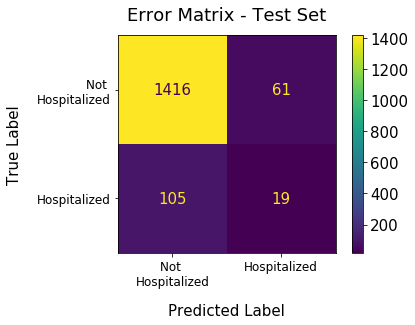

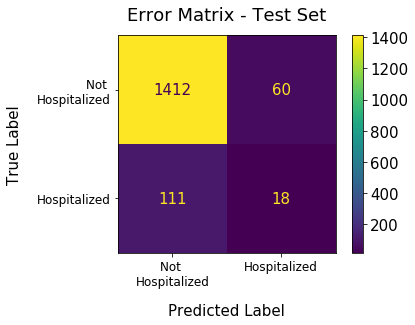

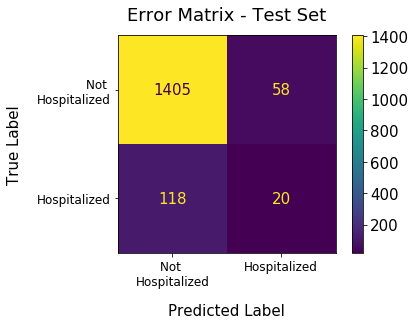

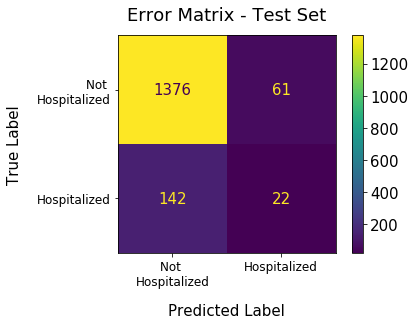

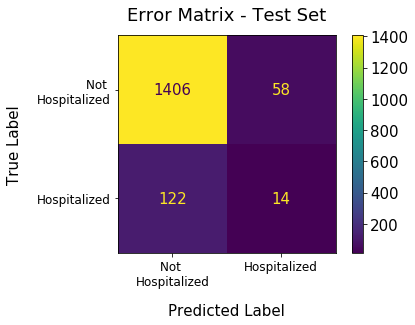

In [12]:
# test a decision tree
# extremely overfit!
# recall is low

tree = DecisionTreeClassifier()

ut.k_fold_validator(X_training, y_training, tree)

### Model 5: Decision Tree with continuous variables and balanced class weight

Classifier: DecisionTreeClassifier(class_weight='balanced')
Cross-validation folds: 5


Train mean recall: 0.77 +/- 0.01
Train mean precision: 0.4 +/- 0.02
Train mean ROC-AUC: 0.83 +/- 0.0


Test mean recall: 0.25 +/- 0.03
Test mean precision: 0.13 +/- 0.01
Test mean ROC-AUC: 0.55 +/- 0.01


Feature weights: 
                  weight  abs_weight
RIDAGEYR        0.46110     0.46110
yrs_heart_cond  0.10390     0.10390
yrs_osteoarth   0.09850     0.09850
yrs_diabetes    0.09140     0.09140
yrs_asthma      0.08430     0.08430
yrs_other_arth  0.08100     0.08100
yrs_taking_ins  0.02140     0.02140
ever_had_COPD   0.01770     0.01770
yrs_heart_fail  0.01480     0.01480
yrs_chron_bronc 0.01420     0.01420
yrs_emphysema   0.01180     0.01180 

Confusion matrices for each fold test set: 



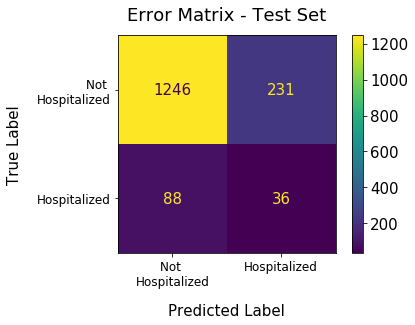

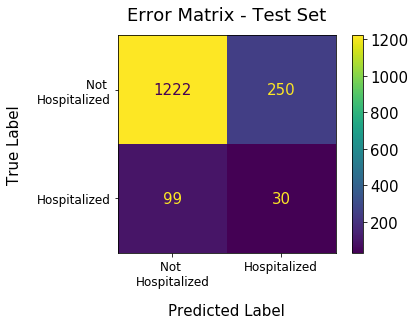

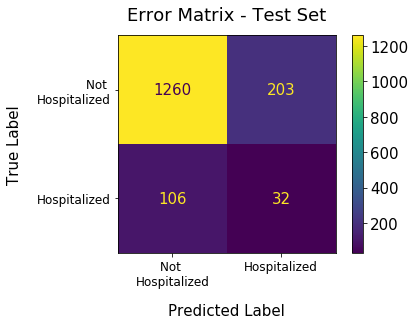

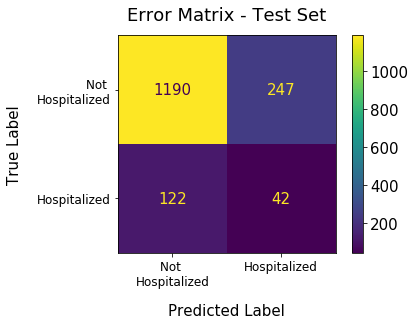

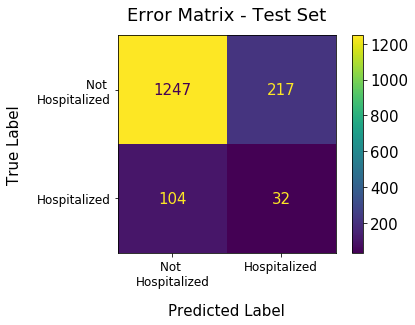

In [13]:
# try a decision tree with balanced class weight
# recall improved, but still overfit

tree = DecisionTreeClassifier(class_weight='balanced')

ut.k_fold_validator(X_training, y_training, tree)

### Model 6: Pruned Decision Tree with continuous variables and balanced class weight

Classifier: DecisionTreeClassifier(class_weight='balanced', max_features=10,
                       min_samples_leaf=10, min_samples_split=10)
Cross-validation folds: 5


Train mean recall: 0.72 +/- 0.02
Train mean precision: 0.24 +/- 0.01
Train mean ROC-AUC: 0.75 +/- 0.0


Test mean recall: 0.5 +/- 0.04
Test mean precision: 0.17 +/- 0.02
Test mean ROC-AUC: 0.63 +/- 0.01


Feature weights: 
                  weight  abs_weight
RIDAGEYR        0.58210     0.58210
yrs_heart_cond  0.14200     0.14200
yrs_osteoarth   0.07850     0.07850
yrs_diabetes    0.05920     0.05920
yrs_other_arth  0.05630     0.05630
yrs_asthma      0.04910     0.04910
ever_had_COPD   0.02260     0.02260
yrs_emphysema   0.00420     0.00420
yrs_chron_bronc 0.00330     0.00330
yrs_heart_fail  0.00270     0.00270
yrs_taking_ins  0.00000     0.00000 

Confusion matrices for each fold test set: 



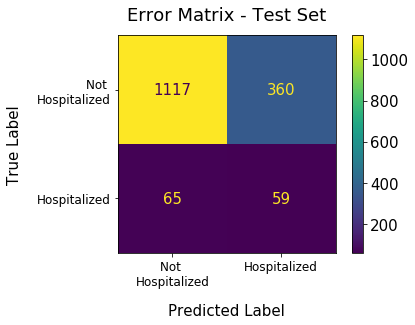

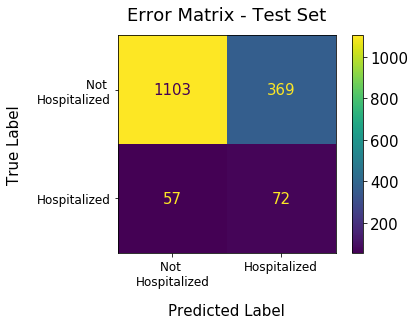

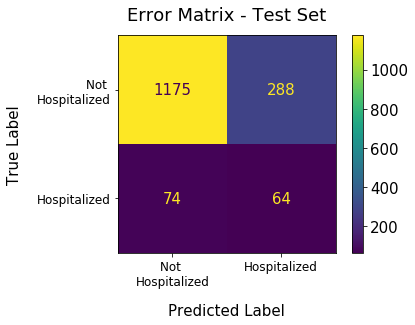

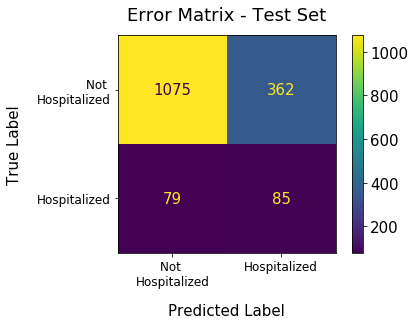

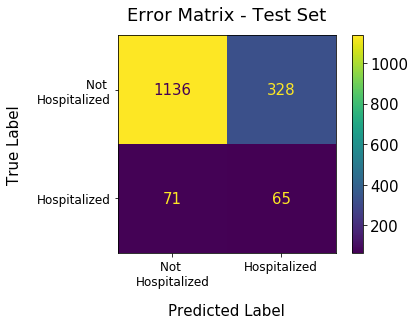

In [14]:
# try to prune the tree
# I used a grid search to get these hyperparameters with scoring=recall
# recall is better but this is still overfit

tree = DecisionTreeClassifier(class_weight='balanced', max_features=10, min_samples_leaf=10, min_samples_split=10)

ut.k_fold_validator(X_training, y_training, tree)

### Model 7: Better Pruned Decision Tree with continuous variables and balanced class weight

Classifier: DecisionTreeClassifier(class_weight='balanced', max_depth=6,
                       min_samples_split=300)
Cross-validation folds: 5


Train mean recall: 0.6 +/- 0.06
Train mean precision: 0.21 +/- 0.03
Train mean ROC-AUC: 0.69 +/- 0.0


Test mean recall: 0.53 +/- 0.09
Test mean precision: 0.19 +/- 0.04
Test mean ROC-AUC: 0.66 +/- 0.02


Feature weights: 
                  weight  abs_weight
RIDAGEYR        0.63710     0.63710
yrs_heart_cond  0.21600     0.21600
yrs_osteoarth   0.07370     0.07370
ever_had_COPD   0.03580     0.03580
yrs_asthma      0.01710     0.01710
yrs_diabetes    0.01040     0.01040
yrs_taking_ins  0.00560     0.00560
yrs_heart_fail  0.00440     0.00440
yrs_other_arth  0.00000     0.00000
yrs_emphysema   0.00000     0.00000
yrs_chron_bronc 0.00000     0.00000 

Confusion matrices for each fold test set: 



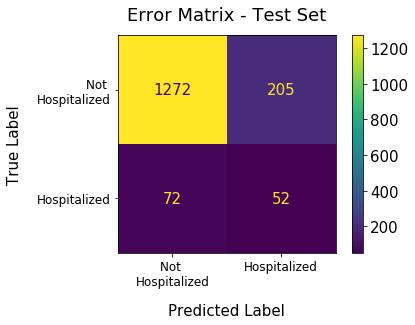

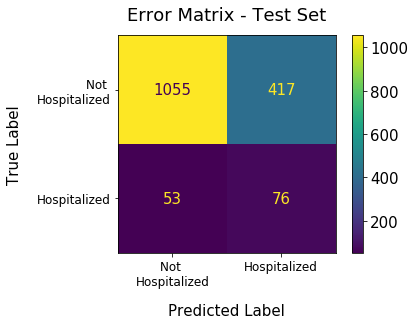

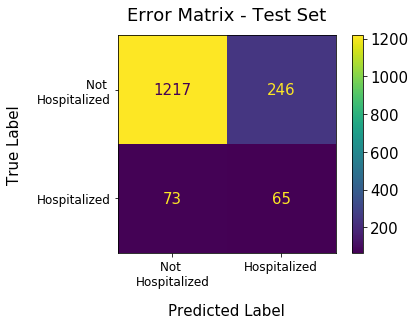

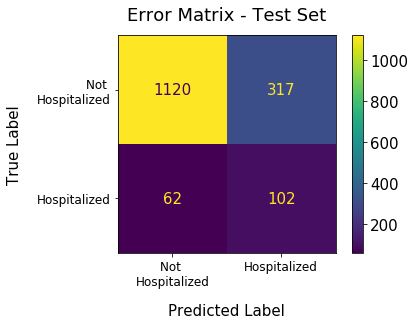

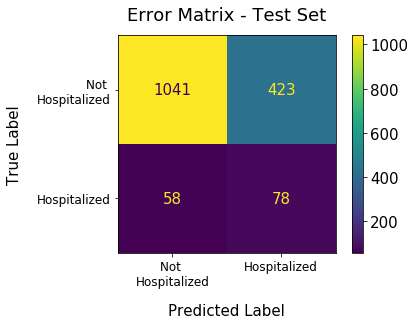

In [15]:
# I used manual testing to get these hyperparameters
# kept increasing min_samples_split
# test recall plateaued at min_samples_split=300
# much less overfit
# test precision doesn't quite meet 0.2 threshold

tree = DecisionTreeClassifier(class_weight='balanced', max_depth=6, min_samples_split=300)

ut.k_fold_validator(X_training, y_training, tree)

### Model 8: Logistic Regression with binary variables and balanced class weight

Models 8-12 test whether binary variables work better than the continuous (years-based) variables used above.  Since logistic regression, naive Bayes, and decision tree models all showed potential, I will continue to test them all here.

In [16]:
binary_df = pd.read_csv('data/binary_df').set_index('SEQN')

In [17]:
# minority class is  8.5%, as above

binary_df['HUQ071'].value_counts(normalize=True)

0.00000   0.91455
1.00000   0.08545
Name: HUQ071, dtype: float64

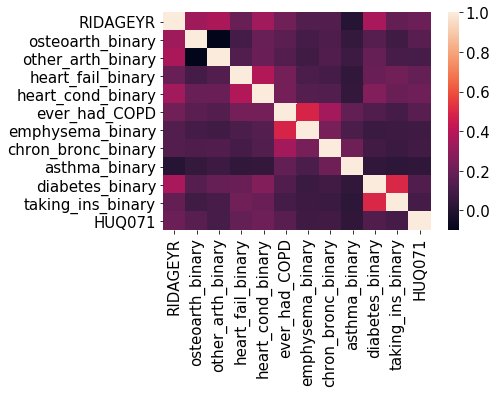

In [18]:
corr = binary_df.corr()
sns.heatmap(corr)

# no strong correlations
# even diabetes and taking insulin is only 50% correlated
# nothing is strongly correlated with hospitalization (HUQ071)

In [19]:
# define X and y

X = binary_df.drop(columns = 'HUQ071')
y = binary_df['HUQ071']

In [20]:
# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.1, random_state=807)

Classifier: LogisticRegression(class_weight='balanced')
Cross-validation folds: 5


Train mean recall: 0.61 +/- 0.01
Train mean precision: 0.19 +/- 0.01
Train mean ROC-AUC: 0.68 +/- 0.0


Test mean recall: 0.6 +/- 0.02
Test mean precision: 0.18 +/- 0.02
Test mean ROC-AUC: 0.67 +/- 0.01


Feature weights: 
                     weight  abs_weight
RIDAGEYR           1.26170     1.26170
heart_cond_binary  0.89160     0.89160
heart_fail_binary  0.86460     0.86460
osteoarth_binary   0.75930     0.75930
ever_had_COPD      0.53660     0.53660
other_arth_binary  0.32840     0.32840
asthma_binary      0.18080     0.18080
emphysema_binary   0.14910     0.14910
diabetes_binary    0.14540     0.14540
chron_bronc_binary 0.12450     0.12450
taking_ins_binary  0.12410     0.12410 

Confusion matrices for each fold test set: 



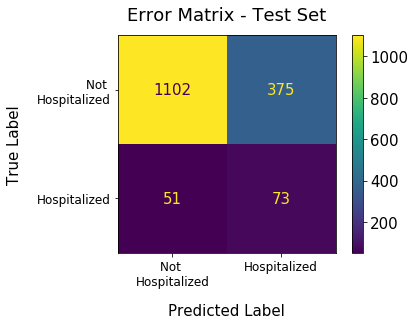

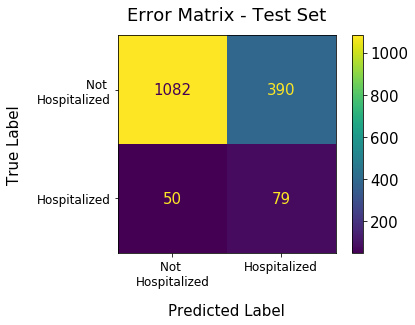

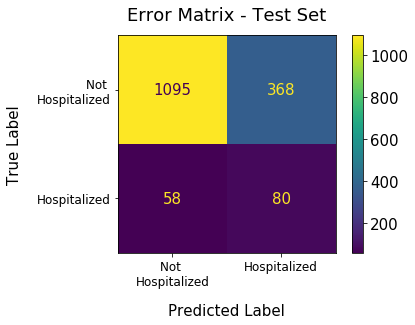

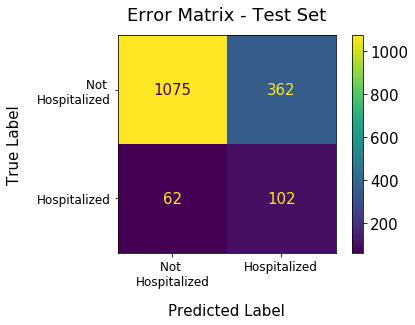

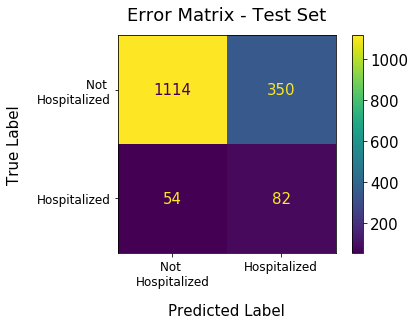

In [21]:
# try a Logistic Regression with binary variables balanced class weight
# recall is slightly worse, but precision is closer to the 0.2 threshold
# so this is better than Model 2, logistic regression with continuous variables and balanced class weight

logreg = LogisticRegression(class_weight='balanced')

ut.k_fold_validator(X_training, y_training, logreg)

### Model 9: Complement Naive Bayes model with binary variables

Classifier: ComplementNB()
Cross-validation folds: 5


Train mean recall: 0.41 +/- 0.02
Train mean precision: 0.26 +/- 0.02
Train mean ROC-AUC: 0.65 +/- 0.0


Test mean recall: 0.41 +/- 0.05
Test mean precision: 0.26 +/- 0.03
Test mean ROC-AUC: 0.65 +/- 0.02


Feature weights: 
                     weight  abs_weight
emphysema_binary   4.66390     4.66390
heart_fail_binary  4.21200     4.21200
chron_bronc_binary 4.05590     4.05590
taking_ins_binary  3.69590     3.69590
ever_had_COPD      3.56530     3.56530
heart_cond_binary  2.81920     2.81920
osteoarth_binary   2.62620     2.62620
asthma_binary      2.36340     2.36340
diabetes_binary    2.33120     2.33120
other_arth_binary  2.24040     2.24040
RIDAGEYR           0.74310     0.74310 

Confusion matrices for each fold test set: 



/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


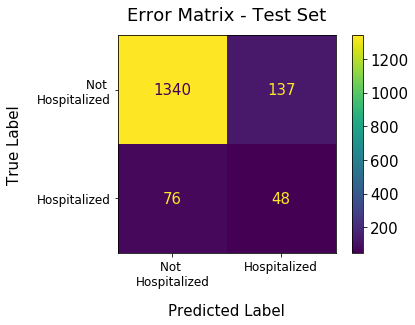

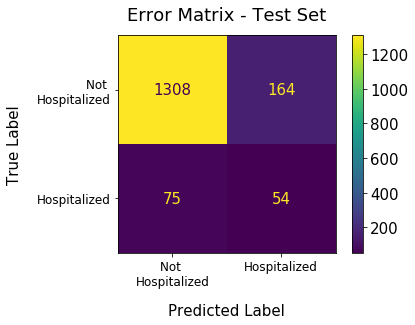

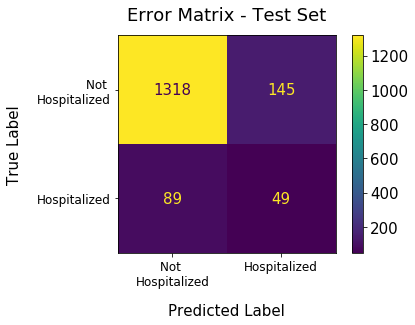

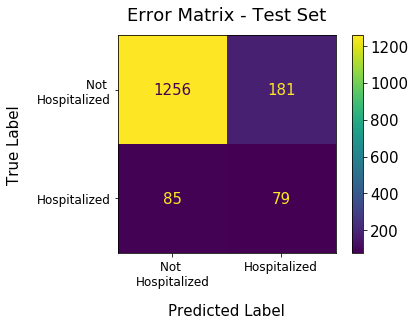

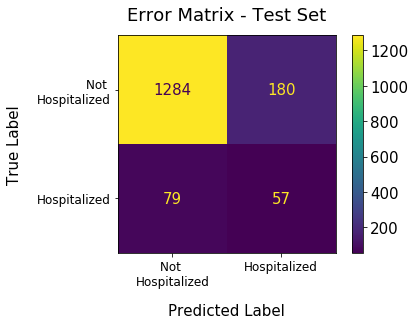

In [22]:
# try a complement naive Bayes
# recall is much better than in Model 3, Complement Naive Bayes with continuous variables

CompNB = ComplementNB()

ut.k_fold_validator(X_training, y_training, CompNB)

### Model 10: Decision Tree with binary variables and balanced class weight

Classifier: DecisionTreeClassifier(class_weight='balanced')
Cross-validation folds: 5


Train mean recall: 0.77 +/- 0.01
Train mean precision: 0.28 +/- 0.01
Train mean ROC-AUC: 0.79 +/- 0.0


Test mean recall: 0.36 +/- 0.03
Test mean precision: 0.13 +/- 0.01
Test mean ROC-AUC: 0.57 +/- 0.01


Feature weights: 
                     weight  abs_weight
RIDAGEYR           0.62150     0.62150
heart_cond_binary  0.09230     0.09230
diabetes_binary    0.05920     0.05920
asthma_binary      0.05340     0.05340
osteoarth_binary   0.04400     0.04400
other_arth_binary  0.02780     0.02780
ever_had_COPD      0.02600     0.02600
taking_ins_binary  0.02600     0.02600
chron_bronc_binary 0.02120     0.02120
emphysema_binary   0.01540     0.01540
heart_fail_binary  0.01310     0.01310 

Confusion matrices for each fold test set: 



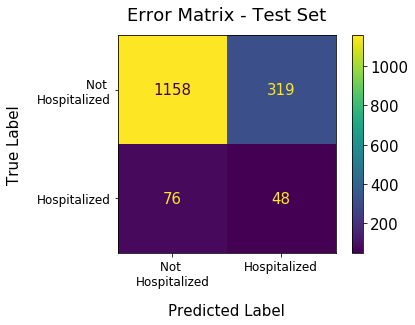

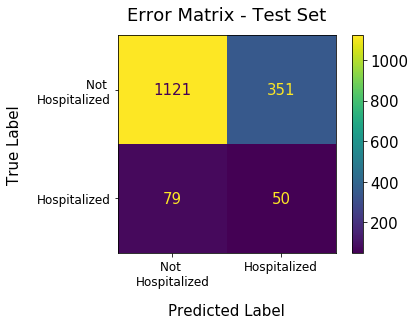

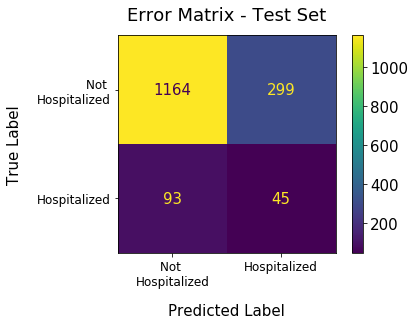

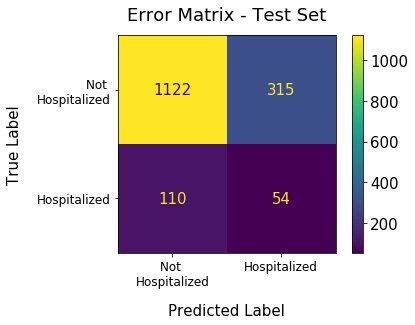

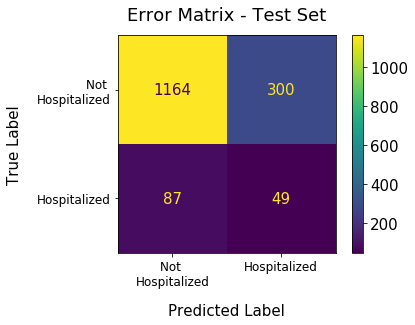

In [23]:
# overfit, as before

tree = DecisionTreeClassifier(class_weight='balanced')

ut.k_fold_validator(X_training, y_training, tree)

### Model 11: Pruned Decision Tree with binary variables and balanced class weight

Classifier: DecisionTreeClassifier(class_weight='balanced', max_features=10,
                       min_samples_leaf=10, min_samples_split=8)
Cross-validation folds: 5


Train mean recall: 0.73 +/- 0.01
Train mean precision: 0.21 +/- 0.01
Train mean ROC-AUC: 0.73 +/- 0.0


Test mean recall: 0.58 +/- 0.05
Test mean precision: 0.16 +/- 0.01
Test mean ROC-AUC: 0.65 +/- 0.01


Feature weights: 
                     weight  abs_weight
RIDAGEYR           0.59570     0.59570
heart_cond_binary  0.25130     0.25130
osteoarth_binary   0.04480     0.04480
ever_had_COPD      0.02690     0.02690
diabetes_binary    0.02690     0.02690
other_arth_binary  0.02650     0.02650
asthma_binary      0.01930     0.01930
heart_fail_binary  0.00380     0.00380
chron_bronc_binary 0.00350     0.00350
taking_ins_binary  0.00120     0.00120
emphysema_binary   0.00000     0.00000 

Confusion matrices for each fold test set: 



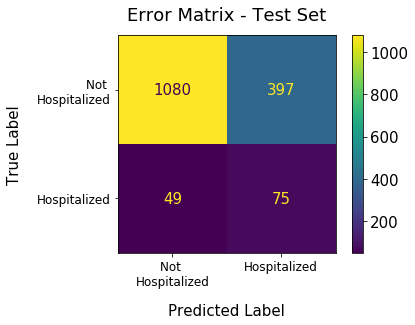

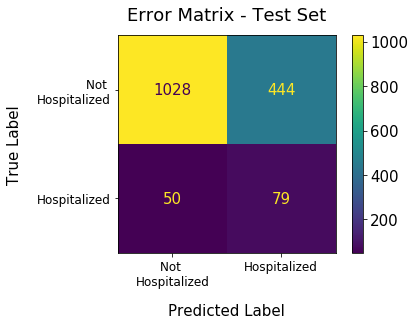

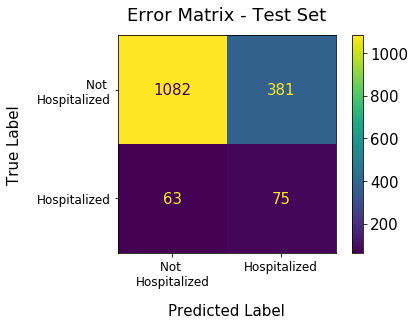

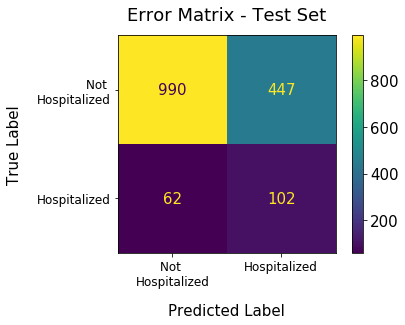

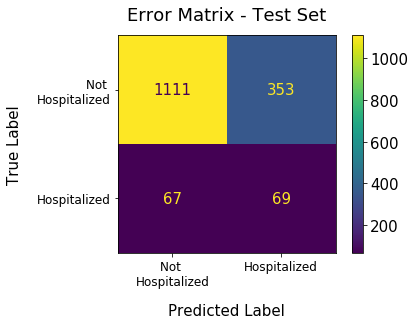

In [24]:
# still overfit, as before

tree = DecisionTreeClassifier(class_weight='balanced', 
                              max_features=10,
                              min_samples_leaf=10, 
                              min_samples_split=8)

ut.k_fold_validator(X_training, y_training, tree)

### Model 12: Better pruned Decision Tree with binary variables

Classifier: DecisionTreeClassifier(class_weight='balanced', max_depth=6,
                       min_samples_split=300)
Cross-validation folds: 5


Train mean recall: 0.62 +/- 0.07
Train mean precision: 0.2 +/- 0.03
Train mean ROC-AUC: 0.69 +/- 0.0


Test mean recall: 0.58 +/- 0.07
Test mean precision: 0.19 +/- 0.04
Test mean ROC-AUC: 0.67 +/- 0.02


Feature weights: 
                     weight  abs_weight
RIDAGEYR           0.67810     0.67810
heart_cond_binary  0.20400     0.20400
osteoarth_binary   0.05420     0.05420
ever_had_COPD      0.03910     0.03910
asthma_binary      0.01320     0.01320
diabetes_binary    0.00690     0.00690
heart_fail_binary  0.00460     0.00460
other_arth_binary  0.00000     0.00000
emphysema_binary   0.00000     0.00000
chron_bronc_binary 0.00000     0.00000
taking_ins_binary  0.00000     0.00000 

Confusion matrices for each fold test set: 



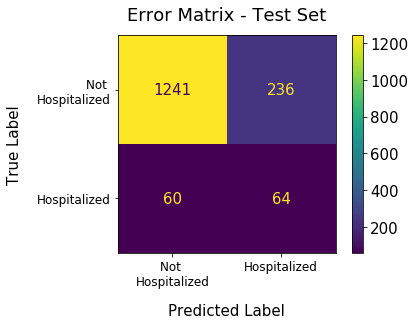

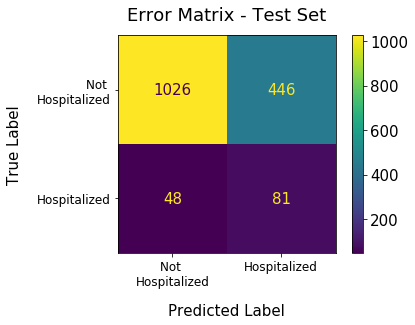

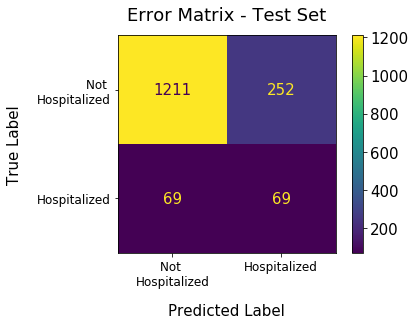

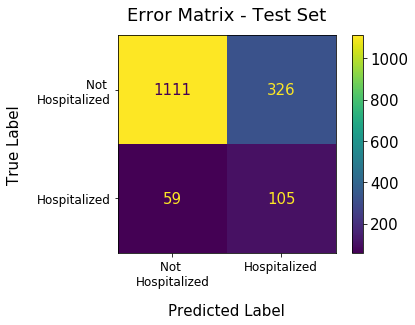

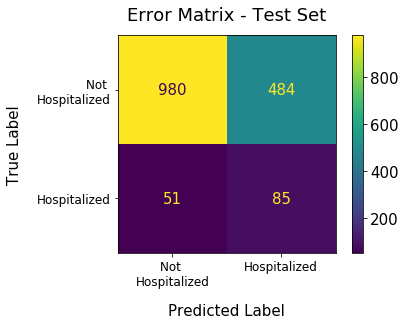

In [25]:
# recall improved over Model 7, better pruned tree with continuous variables
# precision stayed the same, 0.19

tree = DecisionTreeClassifier(class_weight='balanced', max_depth=6, min_samples_split=300)

ut.k_fold_validator(X_training, y_training, tree)

### Model 13: Random Forest Classifier with binary variables

Classifier: RandomForestClassifier(class_weight='balanced', max_depth=6,
                       min_samples_split=300)
Cross-validation folds: 5


Train mean recall: 0.62 +/- 0.0
Train mean precision: 0.19 +/- 0.01
Train mean ROC-AUC: 0.69 +/- 0.0


Test mean recall: 0.62 +/- 0.03
Test mean precision: 0.19 +/- 0.02
Test mean ROC-AUC: 0.68 +/- 0.01


Feature weights: 
                     weight  abs_weight
RIDAGEYR           0.45580     0.45580
heart_cond_binary  0.18960     0.18960
osteoarth_binary   0.12700     0.12700
ever_had_COPD      0.05410     0.05410
heart_fail_binary  0.05240     0.05240
diabetes_binary    0.05200     0.05200
other_arth_binary  0.04040     0.04040
asthma_binary      0.00880     0.00880
chron_bronc_binary 0.00710     0.00710
taking_ins_binary  0.00650     0.00650
emphysema_binary   0.00620     0.00620 

Confusion matrices for each fold test set: 



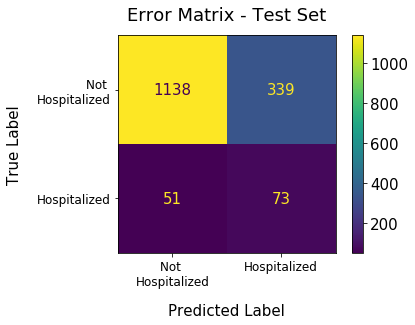

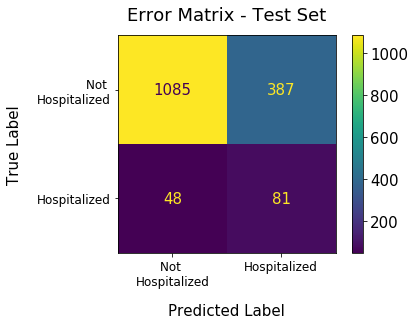

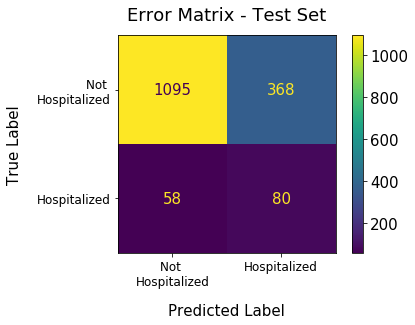

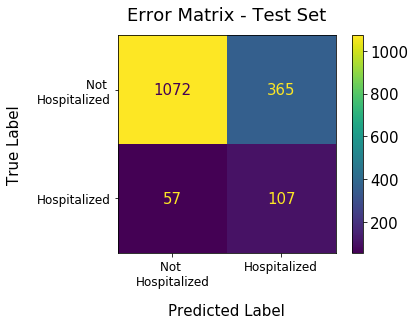

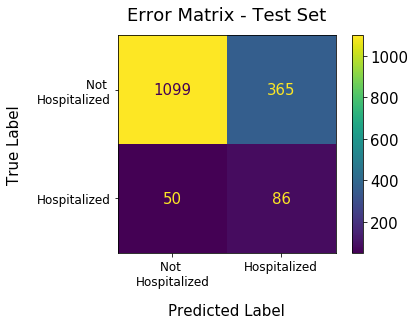

In [26]:
# looks like for all models, binary variables work better than continuous
# since the decision tree shows promise, test a random forest
# recall improved over decision tree, precision still at 0.19

forest = RandomForestClassifier(n_estimators=100, 
                                criterion='gini', 
                                max_depth=6, 
                                min_samples_split=300,
                                class_weight='balanced')

ut.k_fold_validator(X_training, y_training, forest, cv=5)

### Model 14: Logistic Regression with binary variables, balanced class weight, updated hospitalizations

Models 16- test an updated target, in which participants whose only hospitalization was for childbirth were not labeled as hospitalized.  From here on, all models use binary variables for medical conditions.

In [27]:
# try with updated non-birth hospitalizations

binary_df_2 = pd.read_csv('data/binary_df_2').set_index('SEQN')
binary_df_2

RIDAGEYR  osteoarth_binary  other_arth_binary  \
SEQN                                                          
93703.00000    2.00000           0.00000            0.00000   
93704.00000    2.00000           0.00000            0.00000   
93705.00000   66.00000           0.00000            1.00000   
93706.00000   18.00000           0.00000            0.00000   
93707.00000   13.00000           0.00000            0.00000   
...                ...               ...                ...   
102952.00000  70.00000           0.00000            0.00000   
102953.00000  42.00000           0.00000            0.00000   
102954.00000  41.00000           0.00000            0.00000   
102955.00000  14.00000           0.00000            0.00000   
102956.00000  38.00000           1.00000            0.00000   

              heart_fail_binary  heart_cond_binary  ever_had_COPD  \
SEQN                                                                
93703.00000             0.00000            0.00000        0.00000   
93704.00000             0.00000            0.00000        0.00000   
93705.00000             0.00000            0.00000        0.00000   
93706.00000             0.00000            0.00000        0.00000   
93707.00000             0.00000            0.00000        0.00000   
...                         ...                ...            ...   
102952.00000            0.00000            0.00000        0.00000   
102953.00000            0.00000            0.00000        0.00000   
102954.00000            0.00000            0.00000        0.00000   
102955.00000            0.00000            0.00000        0.00000   
102956.00000            0.00000            0.00000        0.00000   

              emphysema_binary  chron_bronc_binary  asthma_binary  \
SEQN                                                                
93703.00000            0.00000             0.00000        0.00000   
93704.00000            0.00000             0.00000        0.00000   
93705.00000            0.00000             0.00000        0.00000   
93706.00000            0.00000             0.00000        0.00000   
93707.00000            0.00000             0.00000        0.00000   
...                        ...                 ...            ...   
102952.00000           0.00000             0.00000        0.00000   
102953.00000           0.00000             0.00000        0.00000   
102954.00000           0.00000             0.00000        0.00000   
102955.00000           0.00000             0.00000        0.00000   
102956.00000           0.00000             0.00000        0.00000   

              diabetes_binary  taking_ins_binary  updated_hosp  
SEQN                                                            
93703.00000           0.00000            0.00000       0.00000  
93704.00000           0.00000            0.00000       0.00000  
93705.00000           0.00000            0.00000       0.00000  
93706.00000           0.00000            0.00000       0.00000  
93707.00000           0.00000            0.00000       0.00000  
...                       ...                ...           ...  
102952.00000          0.00000            0.00000       0.00000  
102953.00000          0.00000            0.00000       0.00000  
102954.00000          0.00000            0.00000       0.00000  
102955.00000          0.00000            0.00000       0.00000  
102956.00000          0.00000            0.00000       0.00000  

[8894 rows x 12 columns]

In [28]:
# define X and y

X = binary_df_2.drop(columns = 'updated_hosp')
y = binary_df_2['updated_hosp']

In [29]:
# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.1, random_state=807)

Classifier: LogisticRegression(class_weight='balanced')
Cross-validation folds: 5


Train mean recall: 0.64 +/- 0.01
Train mean precision: 0.19 +/- 0.01
Train mean ROC-AUC: 0.7 +/- 0.0


Test mean recall: 0.63 +/- 0.02
Test mean precision: 0.19 +/- 0.02
Test mean ROC-AUC: 0.7 +/- 0.01


Feature weights: 
                     weight  abs_weight
RIDAGEYR           1.36560     1.36560
heart_cond_binary  0.94720     0.94720
heart_fail_binary  0.88350     0.88350
osteoarth_binary   0.84930     0.84930
ever_had_COPD      0.49940     0.49940
other_arth_binary  0.42070     0.42070
emphysema_binary   0.20890     0.20890
chron_bronc_binary 0.17320     0.17320
diabetes_binary    0.16950     0.16950
asthma_binary      0.14650     0.14650
taking_ins_binary  0.14370     0.14370 

Confusion matrices for each fold test set: 



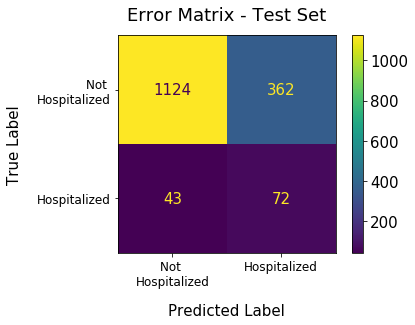

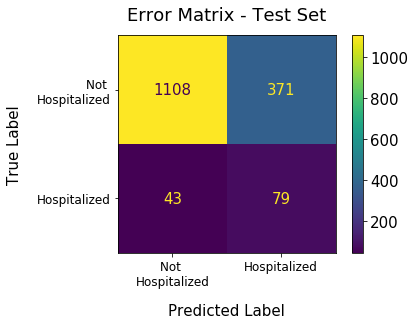

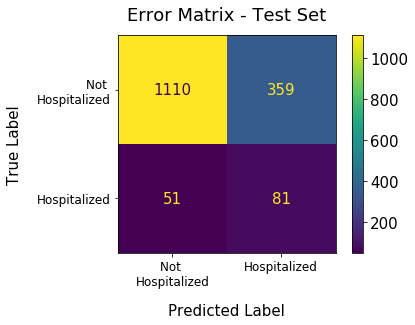

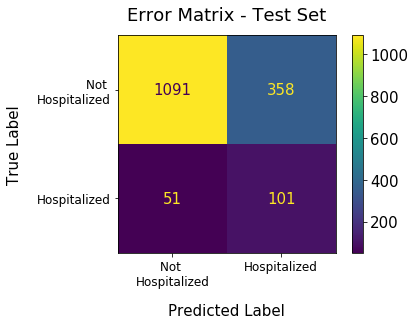

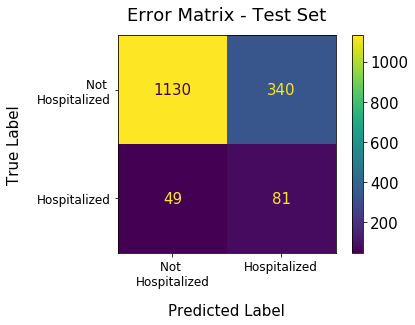

In [30]:
# try a Logistic Regression
# both recall and precision improved over Model 8

logreg = LogisticRegression(class_weight='balanced')

ut.k_fold_validator(X_training, y_training, logreg)

### Model 15: Complement Naive Bayes model with binary variables and updated target

Classifier: ComplementNB()
Cross-validation folds: 5


Train mean recall: 0.44 +/- 0.01
Train mean precision: 0.26 +/- 0.02
Train mean ROC-AUC: 0.66 +/- 0.0


Test mean recall: 0.44 +/- 0.06
Test mean precision: 0.26 +/- 0.03
Test mean ROC-AUC: 0.66 +/- 0.02


Feature weights: 
                     weight  abs_weight
emphysema_binary   4.66730     4.66730
heart_fail_binary  4.21540     4.21540
chron_bronc_binary 4.05940     4.05940
taking_ins_binary  3.69930     3.69930
ever_had_COPD      3.56190     3.56190
heart_cond_binary  2.82260     2.82260
osteoarth_binary   2.62960     2.62960
asthma_binary      2.35870     2.35870
diabetes_binary    2.33260     2.33260
other_arth_binary  2.24380     2.24380
RIDAGEYR           0.74180     0.74180 

Confusion matrices for each fold test set: 



/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


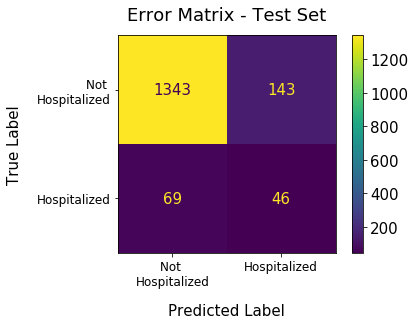

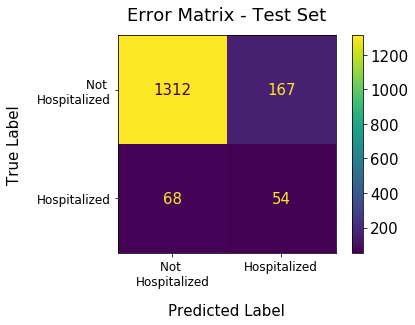

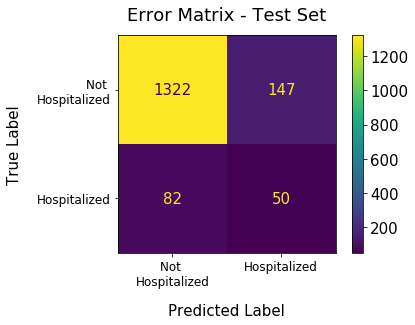

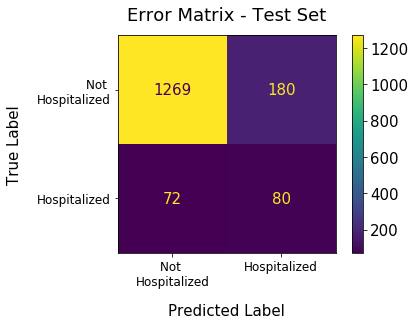

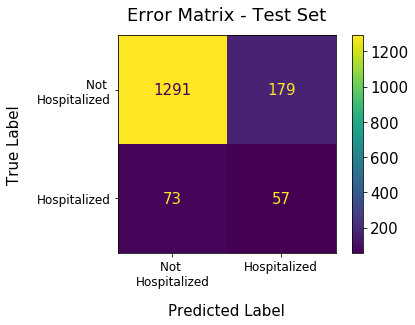

In [31]:
# try a complement naive Bayes
# recall improved over Model 9

CompNB = ComplementNB()

ut.k_fold_validator(X_training, y_training, CompNB)

### Model 16: Random Forest with binary variables and updated target

Classifier: RandomForestClassifier(class_weight='balanced', max_depth=6,
                       min_samples_split=300)
Cross-validation folds: 5


Train mean recall: 0.65 +/- 0.01
Train mean precision: 0.19 +/- 0.01
Train mean ROC-AUC: 0.71 +/- 0.0


Test mean recall: 0.64 +/- 0.03
Test mean precision: 0.19 +/- 0.02
Test mean ROC-AUC: 0.7 +/- 0.01


Feature weights: 
                     weight  abs_weight
RIDAGEYR           0.42480     0.42480
heart_cond_binary  0.21190     0.21190
osteoarth_binary   0.13800     0.13800
diabetes_binary    0.05810     0.05810
heart_fail_binary  0.05260     0.05260
ever_had_COPD      0.04430     0.04430
other_arth_binary  0.04400     0.04400
taking_ins_binary  0.00870     0.00870
chron_bronc_binary 0.00680     0.00680
asthma_binary      0.00630     0.00630
emphysema_binary   0.00450     0.00450 

Confusion matrices for each fold test set: 



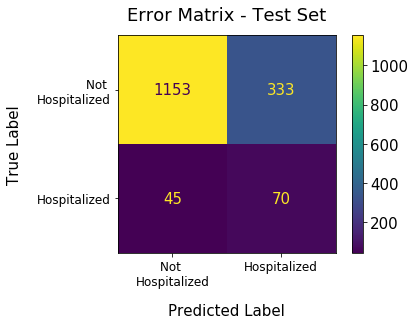

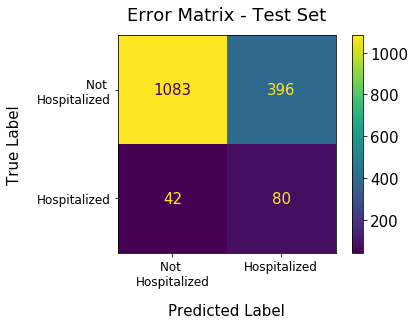

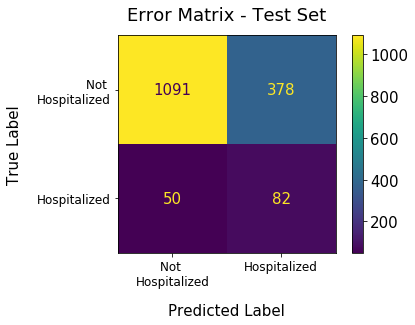

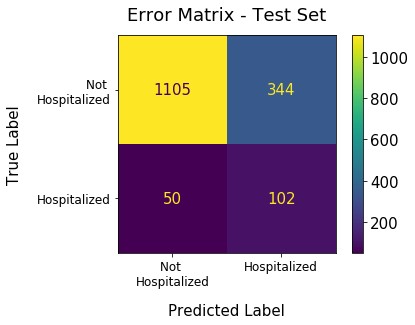

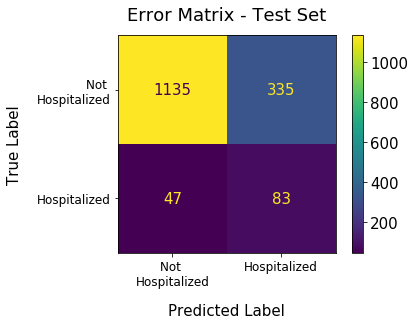

In [32]:
# improved recall over Model 13, precision still slightly too low

ut.k_fold_validator(X_training, y_training, forest, cv=5)

### Model 17: Adaptive Boosted Tree Model

Classifier: AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         criterion='entropy',
                                                         max_depth=2,
                                                         max_features=7,
                                                         max_leaf_nodes=25,
                                                         min_samples_leaf=200,
                                                         min_samples_split=1000),
                   n_estimators=100)
Cross-validation folds: 5


Train mean recall: 0.65 +/- 0.01
Train mean precision: 0.2 +/- 0.01
Train mean ROC-AUC: 0.71 +/- 0.0


Test mean recall: 0.62 +/- 0.05
Test mean precision: 0.19 +/- 0.01
Test mean ROC-AUC: 0.69 +/- 0.02




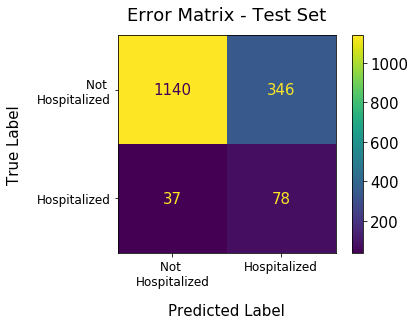

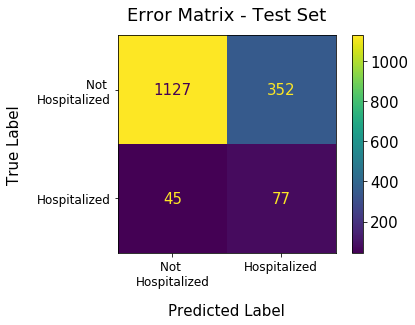

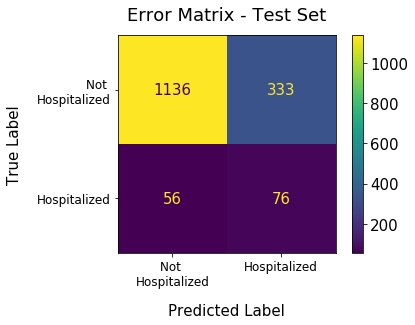

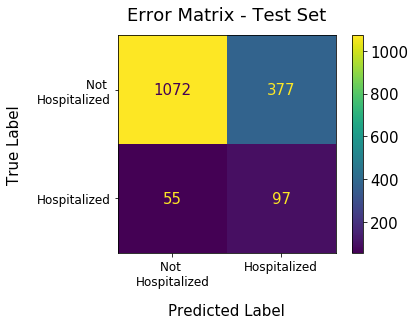

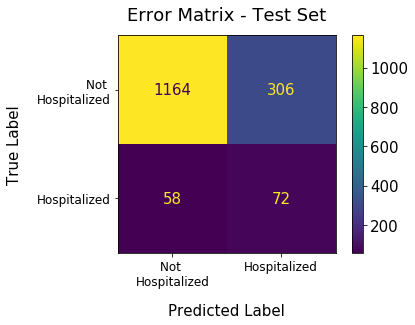

In [33]:
# since the random forest is working well, try adaptive boosted and gradient boosted tree models
# parameters below attained by trial and error to reduce overfitting
# recall worse than random forest

tree = DecisionTreeClassifier(class_weight='balanced',
                              max_features=7,
                              min_samples_leaf=200,
                            max_depth=2,
                            min_samples_split=1000,
                             max_leaf_nodes=25,
                             criterion='entropy')

Ada = AdaBoostClassifier(base_estimator=tree, n_estimators=100)

ut.k_fold_validator(X_training, y_training, Ada, cv=5)

### Model 18: Gradient Boosted Tree Model

Classifier: GradientBoostingClassifier(init=DecisionTreeClassifier(class_weight='balanced',
                                                       criterion='entropy',
                                                       max_depth=2,
                                                       max_features=7,
                                                       max_leaf_nodes=25,
                                                       min_samples_leaf=200,
                                                       min_samples_split=1000),
                           max_depth=2, max_features=7, max_leaf_nodes=25,
                           min_samples_leaf=200, min_samples_split=1000)
Cross-validation folds: 5


Train mean recall: 0.02 +/- 0.01
Train mean precision: 0.52 +/- 0.13
Train mean ROC-AUC: 0.51 +/- 0.0


Test mean recall: 0.02 +/- 0.01
Test mean precision: 0.66 +/- 0.24
Test mean ROC-AUC: 0.51 +/- 0.0




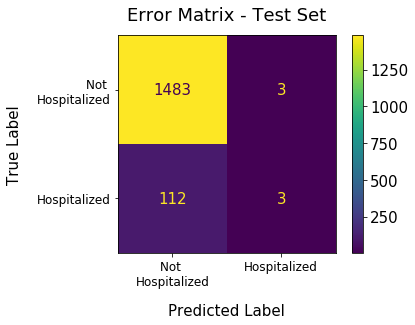

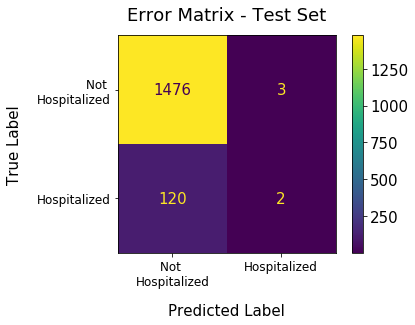

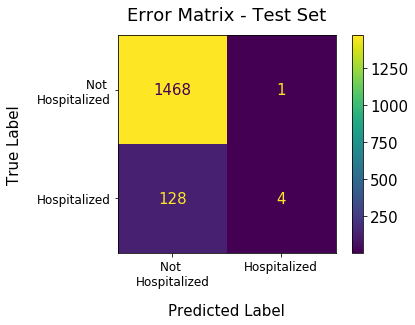

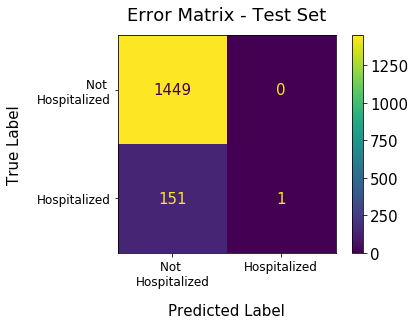

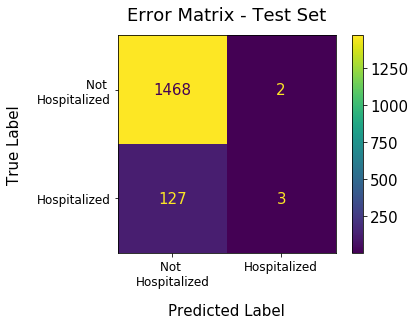

In [34]:
# recall extremely low
# seems to be no way to set recall and precision as the goal rather than reducing mean squared error

GBC = GradientBoostingClassifier(init=tree,
                              max_features=7,
                              min_samples_leaf=200,
                            max_depth=2,
                            min_samples_split=1000,
                             max_leaf_nodes=25)

ut.k_fold_validator(X_training, y_training, GBC, cv=5)

### Model 19: Logistic regression with race feature

In [35]:
# add race

binary_df_3 = pd.read_csv('data/binary_df_3').set_index('SEQN')
binary_df_3.head(200)

RIDAGEYR  osteoarth_binary  other_arth_binary  heart_fail_binary  \
SEQN                                                                            
93703.00000   2.00000           0.00000            0.00000            0.00000   
93704.00000   2.00000           0.00000            0.00000            0.00000   
93705.00000  66.00000           0.00000            1.00000            0.00000   
93706.00000  18.00000           0.00000            0.00000            0.00000   
93707.00000  13.00000           0.00000            0.00000            0.00000   
93708.00000  66.00000           0.00000            0.00000            0.00000   
93709.00000  75.00000           0.00000            1.00000            0.00000   
93711.00000  56.00000           0.00000            0.00000            0.00000   
93712.00000  18.00000           0.00000            0.00000            0.00000   
93713.00000  67.00000           0.00000            1.00000            0.00000   
93714.00000  54.00000           0.00000            0.00000            0.00000   
93715.00000  71.00000           1.00000            0.00000            0.00000   
93716.00000  61.00000           0.00000            1.00000            0.00000   
93717.00000  22.00000           0.00000            0.00000            0.00000   
93718.00000  45.00000           0.00000            0.00000            0.00000   
93719.00000  13.00000           0.00000            0.00000            0.00000   
93720.00000   1.00000           0.00000            0.00000            0.00000   
93721.00000  60.00000           0.00000            0.00000            0.00000   
93722.00000  60.00000           0.00000            0.00000            0.00000   
93723.00000  64.00000           1.00000            0.00000            0.00000   
93724.00000   5.00000           0.00000            0.00000            0.00000   
93725.00000   9.00000           0.00000            0.00000            0.00000   
93726.00000  67.00000           0.00000            0.00000            0.00000   
93727.00000  70.00000           0.00000            0.00000            0.00000   
93728.00000  53.00000           0.00000            0.00000            0.00000   
93729.00000  42.00000           0.00000            0.00000            0.00000   
93730.00000  57.00000           0.00000            0.00000            0.00000   
93731.00000  20.00000           0.00000            0.00000            0.00000   
93732.00000  72.00000           0.00000            0.00000            0.00000   
93733.00000  11.00000           0.00000            0.00000            0.00000   
93734.00000  13.00000           0.00000            0.00000            0.00000   
93735.00000  52.00000           0.00000            0.00000            0.00000   
93736.00000  11.00000           0.00000            0.00000            0.00000   
93737.00000   8.00000           0.00000            0.00000            0.00000   
93738.00000  26.00000           0.00000            0.00000            0.00000   
93739.00000   5.00000           0.00000            0.00000            0.00000   
93740.00000  72.00000           0.00000            1.00000            1.00000   
93741.00000   9.00000           0.00000            0.00000            0.00000   
93742.00000  72.00000           1.00000            0.00000            0.00000   
93743.00000  61.00000           0.00000            1.00000            0.00000   
93744.00000  10.00000           0.00000            0.00000            0.00000   
93745.00000   5.00000           0.00000            0.00000            0.00000   
93746.00000  25.00000           0.00000            0.00000            0.00000   
93747.00000  13.00000           0.00000            0.00000            0.00000   
93749.00000   1.00000           0.00000            0.00000            0.00000   
93750.00000  52.00000           0.00000            0.00000            0.00000   
93751.00000   7.00000           0.00000            0.00000            0.00000   
93752.00000  73.00000           0.00000     

In [36]:
# define X and y

X = binary_df_3.drop(columns = 'updated_hosp')
y = binary_df_3['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.1, random_state=807)


Classifier: LogisticRegression(class_weight='balanced')
Cross-validation folds: 5


Train mean recall: 0.64 +/- 0.01
Train mean precision: 0.19 +/- 0.01
Train mean ROC-AUC: 0.7 +/- 0.0


Test mean recall: 0.63 +/- 0.02
Test mean precision: 0.18 +/- 0.02
Test mean ROC-AUC: 0.69 +/- 0.01


Feature weights: 
                      weight  abs_weight
RIDAGEYR            1.38060     1.38060
heart_cond_binary   0.92210     0.92210
heart_fail_binary   0.87970     0.87970
osteoarth_binary    0.79520     0.79520
Non-Hispanic Asian -0.54090     0.54090
ever_had_COPD       0.47650     0.47650
other_arth_binary   0.38430     0.38430
Mexican American   -0.24290     0.24290
diabetes_binary     0.20810     0.20810
Non-Hispanic Black -0.19290     0.19290
emphysema_binary    0.17820     0.17820
taking_ins_binary   0.15780     0.15780
asthma_binary       0.14180     0.14180
chron_bronc_binary  0.12420     0.12420
Other Hispanic      0.10560     0.10560
Non-Hispanic White -0.06220     0.06220 

Confusion 

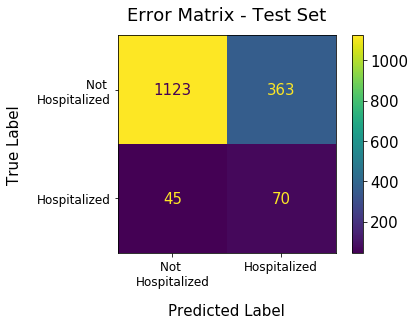

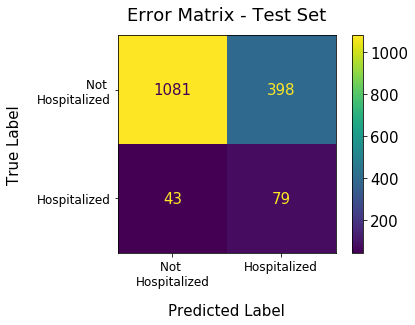

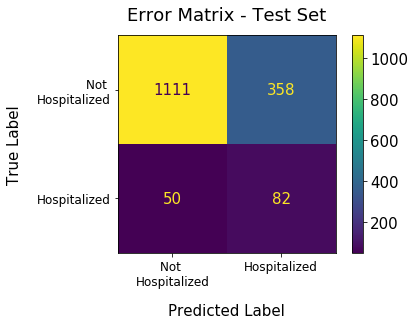

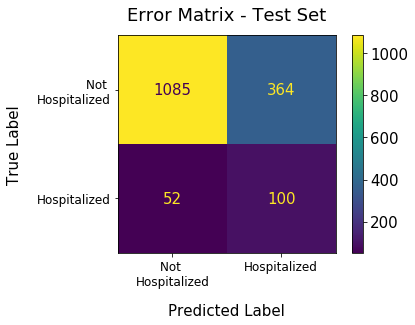

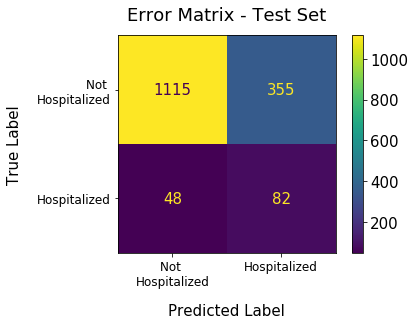

In [37]:
# surprising - precision got slightly worse than in Model 14 (recall 0.63, precision 0.19)

ut.k_fold_validator(X_training, y_training, logreg)

### Model 20: Complement naive bayes with race feature

Classifier: ComplementNB()
Cross-validation folds: 5


Train mean recall: 0.52 +/- 0.02
Train mean precision: 0.23 +/- 0.01
Train mean ROC-AUC: 0.68 +/- 0.01


Test mean recall: 0.52 +/- 0.04
Test mean precision: 0.23 +/- 0.03
Test mean ROC-AUC: 0.68 +/- 0.02


Feature weights: 
                     weight  abs_weight
emphysema_binary   5.38700     5.38700
heart_fail_binary  4.93500     4.93500
chron_bronc_binary 4.77900     4.77900
taking_ins_binary  4.41900     4.41900
ever_had_COPD      4.28160     4.28160
heart_cond_binary  3.54220     3.54220
osteoarth_binary   3.34920     3.34920
asthma_binary      3.07830     3.07830
diabetes_binary    3.05220     3.05220
Other Hispanic     3.04830     3.04830
other_arth_binary  2.96340     2.96340
Non-Hispanic Asian 2.58670     2.58670
Mexican American   2.48310     2.48310
Non-Hispanic Black 2.06210     2.06210
Non-Hispanic White 1.71660     1.71660
RIDAGEYR           1.46140     1.46140 

Confusion matrices for each fold test set: 



/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


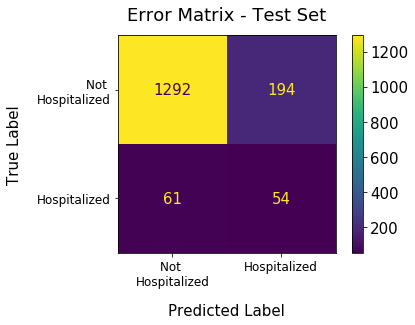

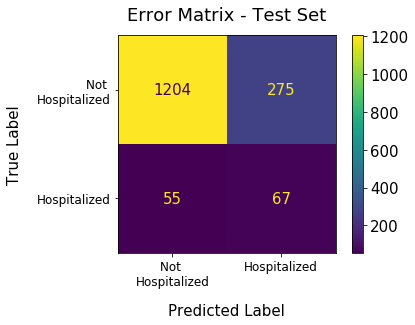

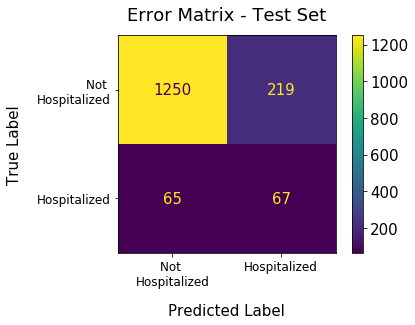

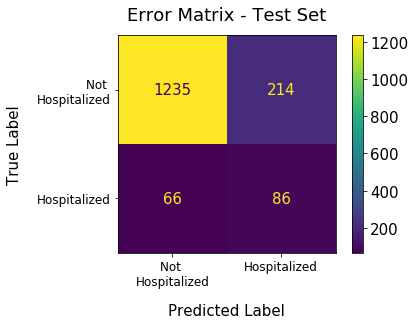

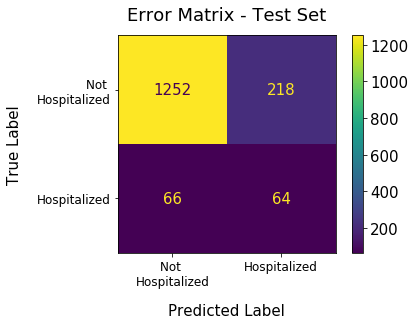

In [38]:
# recall much better

ut.k_fold_validator(X_training, y_training, CompNB)

### Model 21: Random Forest with race feature

Classifier: RandomForestClassifier(class_weight='balanced', max_depth=6,
                       min_samples_split=300)
Cross-validation folds: 5


Train mean recall: 0.65 +/- 0.01
Train mean precision: 0.19 +/- 0.01
Train mean ROC-AUC: 0.7 +/- 0.0


Test mean recall: 0.64 +/- 0.04
Test mean precision: 0.19 +/- 0.02
Test mean ROC-AUC: 0.7 +/- 0.02


Feature weights: 
                     weight  abs_weight
RIDAGEYR           0.36400     0.36400
heart_cond_binary  0.22070     0.22070
osteoarth_binary   0.13160     0.13160
ever_had_COPD      0.05890     0.05890
diabetes_binary    0.05600     0.05600
other_arth_binary  0.05350     0.05350
heart_fail_binary  0.04890     0.04890
Non-Hispanic Asian 0.01480     0.01480
taking_ins_binary  0.01230     0.01230
emphysema_binary   0.00940     0.00940
Non-Hispanic White 0.00690     0.00690
Mexican American   0.00520     0.00520
Other Hispanic     0.00520     0.00520
chron_bronc_binary 0.00510     0.00510
asthma_binary      0.00480     0.00480
Non-Hi

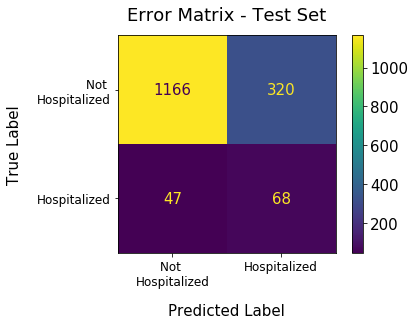

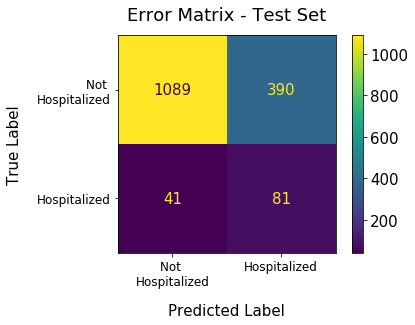

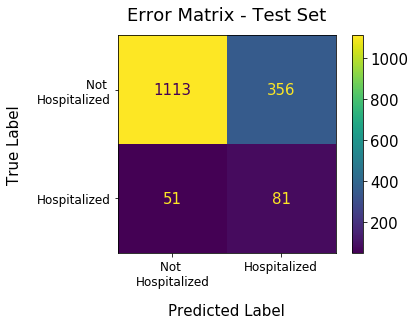

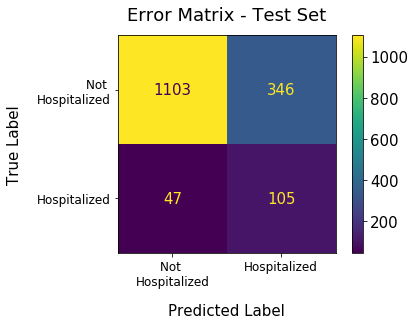

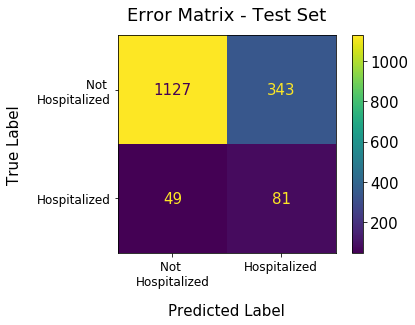

In [39]:
# recall slightly worse!

ut.k_fold_validator(X_training, y_training, forest, cv=5)

### Model 22: Logistic regression with prescription data

In [40]:
# add number of prescriptions per patient

binary_df_4 = pd.read_csv('data/binary_df_4').set_index('SEQN')
binary_df_4.head(200)

RIDAGEYR  osteoarth_binary  other_arth_binary  heart_fail_binary  \
SEQN                                                                            
93703.00000   2.00000           0.00000            0.00000            0.00000   
93704.00000   2.00000           0.00000            0.00000            0.00000   
93705.00000  66.00000           0.00000            1.00000            0.00000   
93706.00000  18.00000           0.00000            0.00000            0.00000   
93707.00000  13.00000           0.00000            0.00000            0.00000   
93708.00000  66.00000           0.00000            0.00000            0.00000   
93709.00000  75.00000           0.00000            1.00000            0.00000   
93711.00000  56.00000           0.00000            0.00000            0.00000   
93712.00000  18.00000           0.00000            0.00000            0.00000   
93713.00000  67.00000           0.00000            1.00000            0.00000   
93714.00000  54.00000           0.00000            0.00000            0.00000   
93715.00000  71.00000           1.00000            0.00000            0.00000   
93716.00000  61.00000           0.00000            1.00000            0.00000   
93717.00000  22.00000           0.00000            0.00000            0.00000   
93718.00000  45.00000           0.00000            0.00000            0.00000   
93719.00000  13.00000           0.00000            0.00000            0.00000   
93720.00000   1.00000           0.00000            0.00000            0.00000   
93721.00000  60.00000           0.00000            0.00000            0.00000   
93722.00000  60.00000           0.00000            0.00000            0.00000   
93723.00000  64.00000           1.00000            0.00000            0.00000   
93724.00000   5.00000           0.00000            0.00000            0.00000   
93725.00000   9.00000           0.00000            0.00000            0.00000   
93726.00000  67.00000           0.00000            0.00000            0.00000   
93727.00000  70.00000           0.00000            0.00000            0.00000   
93728.00000  53.00000           0.00000            0.00000            0.00000   
93729.00000  42.00000           0.00000            0.00000            0.00000   
93730.00000  57.00000           0.00000            0.00000            0.00000   
93731.00000  20.00000           0.00000            0.00000            0.00000   
93732.00000  72.00000           0.00000            0.00000            0.00000   
93733.00000  11.00000           0.00000            0.00000            0.00000   
93734.00000  13.00000           0.00000            0.00000            0.00000   
93735.00000  52.00000           0.00000            0.00000            0.00000   
93736.00000  11.00000           0.00000            0.00000            0.00000   
93737.00000   8.00000           0.00000            0.00000            0.00000   
93738.00000  26.00000           0.00000            0.00000            0.00000   
93739.00000   5.00000           0.00000            0.00000            0.00000   
93740.00000  72.00000           0.00000            1.00000            1.00000   
93741.00000   9.00000           0.00000            0.00000            0.00000   
93742.00000  72.00000           1.00000            0.00000            0.00000   
93743.00000  61.00000           0.00000            1.00000            0.00000   
93744.00000  10.00000           0.00000            0.00000            0.00000   
93745.00000   5.00000           0.00000            0.00000            0.00000   
93746.00000  25.00000           0.00000            0.00000            0.00000   
93747.00000  13.00000           0.00000            0.00000            0.00000   
93749.00000   1.00000           0.00000            0.00000            0.00000   
93750.00000  52.00000           0.00000            0.00000            0.00000   
93751.00000   7.00000           0.00000            0.00000            0.00000   
93752.00000  73.00000           0.00000     

In [41]:
# define X and y

X = binary_df_4.drop(columns = ['updated_hosp'])
y = binary_df_4['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.1, random_state=807)


Classifier: LogisticRegression(class_weight='balanced')
Cross-validation folds: 5


Train mean recall: 0.65 +/- 0.01
Train mean precision: 0.2 +/- 0.01
Train mean ROC-AUC: 0.71 +/- 0.0


Test mean recall: 0.64 +/- 0.03
Test mean precision: 0.19 +/- 0.02
Test mean ROC-AUC: 0.7 +/- 0.01


Feature weights: 
                      weight  abs_weight
num_rx              1.87470     1.87470
RIDAGEYR            1.10960     1.10960
heart_cond_binary   0.83140     0.83140
heart_fail_binary   0.75800     0.75800
osteoarth_binary    0.72380     0.72380
Non-Hispanic Asian -0.48470     0.48470
ever_had_COPD       0.35940     0.35940
other_arth_binary   0.31490     0.31490
emphysema_binary    0.25740     0.25740
Mexican American   -0.21560     0.21560
Non-Hispanic Black -0.16850     0.16850
Other Hispanic      0.14820     0.14820
chron_bronc_binary  0.11150     0.11150
Non-Hispanic White -0.05240     0.05240
asthma_binary       0.04600     0.04600
diabetes_binary     0.03880     0.03880
taking_ins_bi

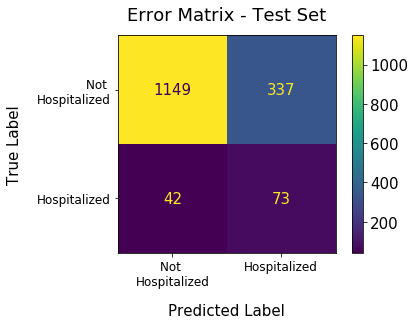

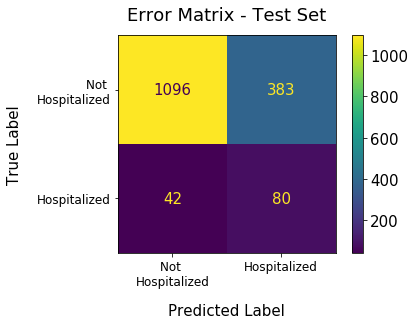

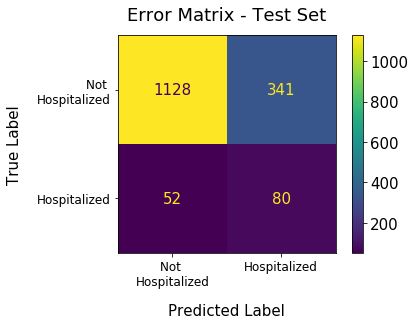

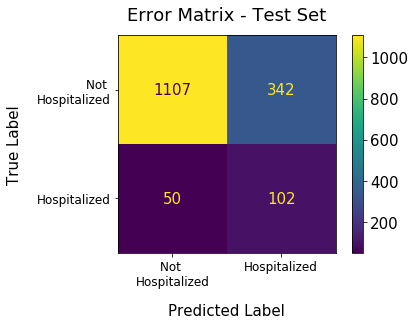

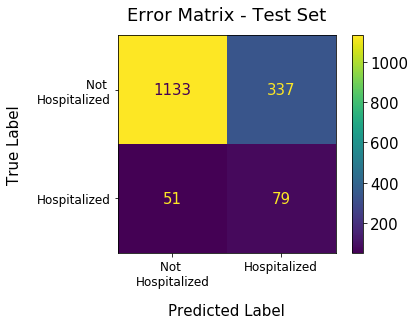

In [42]:
# recall and precision best yet for logistic regression

ut.k_fold_validator(X_training, y_training, logreg)

### Model 23: Complement Naive Bayes with prescription data

Classifier: ComplementNB()
Cross-validation folds: 5


Train mean recall: 0.54 +/- 0.01
Train mean precision: 0.23 +/- 0.01
Train mean ROC-AUC: 0.69 +/- 0.01


Test mean recall: 0.53 +/- 0.04
Test mean precision: 0.23 +/- 0.03
Test mean ROC-AUC: 0.68 +/- 0.02


Feature weights: 
                     weight  abs_weight
emphysema_binary   5.41750     5.41750
heart_fail_binary  4.96550     4.96550
chron_bronc_binary 4.80950     4.80950
taking_ins_binary  4.44950     4.44950
ever_had_COPD      4.31210     4.31210
heart_cond_binary  3.57280     3.57280
num_rx             3.50360     3.50360
osteoarth_binary   3.37970     3.37970
asthma_binary      3.10880     3.10880
diabetes_binary    3.08280     3.08280
Other Hispanic     3.07880     3.07880
other_arth_binary  2.99400     2.99400
Non-Hispanic Asian 2.61720     2.61720
Mexican American   2.51360     2.51360
Non-Hispanic Black 2.09260     2.09260
Non-Hispanic White 1.74720     1.74720
RIDAGEYR           1.49200     1.49200 

Confusion matri

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


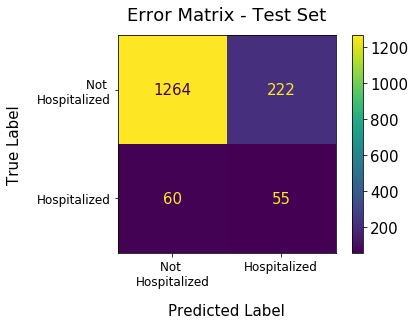

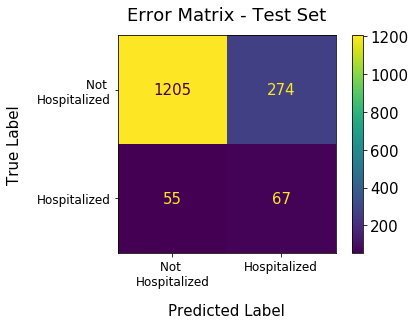

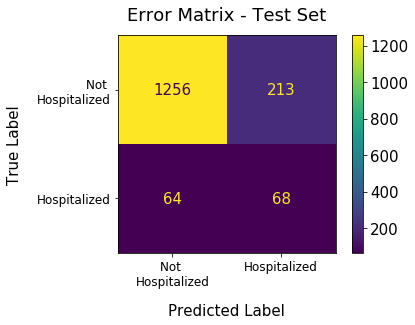

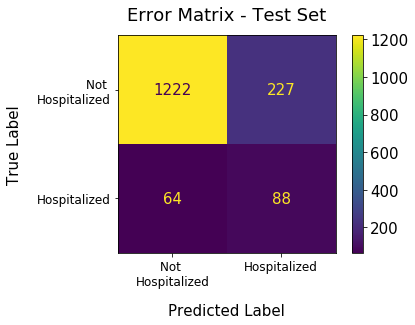

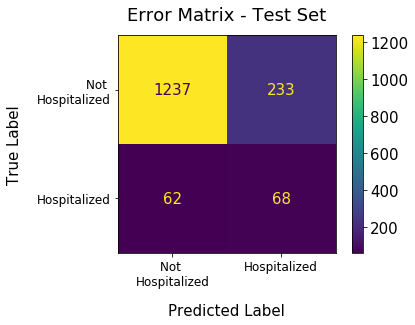

In [43]:
# recall slightly better

ut.k_fold_validator(X_training, y_training, CompNB)

### Model 24: Random Forest with prescription data

Classifier: RandomForestClassifier(class_weight='balanced', max_depth=6,
                       min_samples_split=300)
Cross-validation folds: 5


Train mean recall: 0.69 +/- 0.01
Train mean precision: 0.19 +/- 0.01
Train mean ROC-AUC: 0.72 +/- 0.0


Test mean recall: 0.67 +/- 0.03
Test mean precision: 0.19 +/- 0.02
Test mean ROC-AUC: 0.71 +/- 0.01


Feature weights: 
                     weight  abs_weight
RIDAGEYR           0.29430     0.29430
num_rx             0.28940     0.28940
heart_cond_binary  0.13800     0.13800
osteoarth_binary   0.09420     0.09420
heart_fail_binary  0.05070     0.05070
ever_had_COPD      0.03070     0.03070
other_arth_binary  0.02580     0.02580
diabetes_binary    0.02380     0.02380
Non-Hispanic Asian 0.00950     0.00950
taking_ins_binary  0.00920     0.00920
chron_bronc_binary 0.00750     0.00750
Mexican American   0.00610     0.00610
Other Hispanic     0.00560     0.00560
emphysema_binary   0.00530     0.00530
Non-Hispanic White 0.00510     0.00510
asth

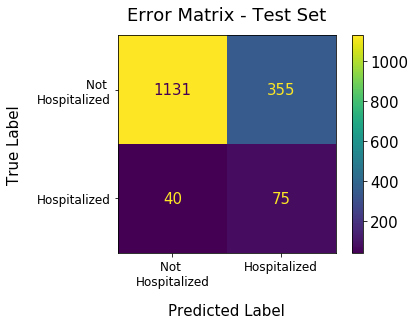

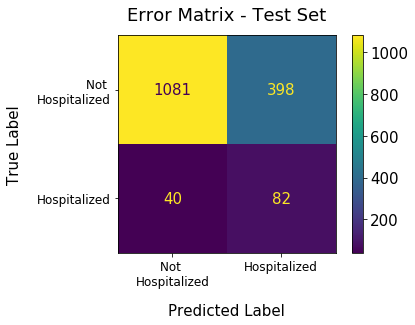

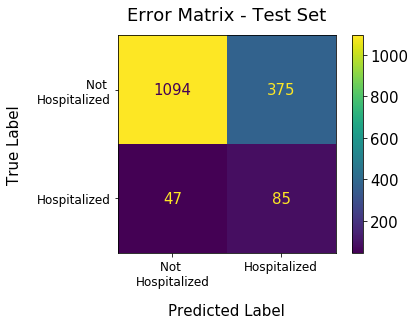

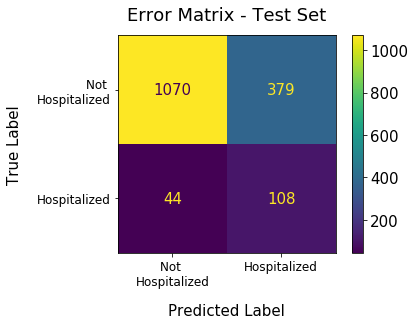

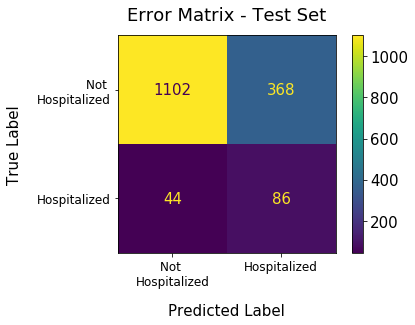

In [44]:
# recall way up, precision still below threshold

ut.k_fold_validator(X_training, y_training, forest, cv=5)

### Model 25: Logistic Regression with unknown prescription diagnosis data

In [45]:
binary_df_5 = pd.read_csv('data/binary_df_5').set_index('SEQN')
binary_df_5

RIDAGEYR  osteoarth_binary  other_arth_binary  \
SEQN                                                          
93703.00000    2.00000           0.00000            0.00000   
93704.00000    2.00000           0.00000            0.00000   
93705.00000   66.00000           0.00000            1.00000   
93706.00000   18.00000           0.00000            0.00000   
93707.00000   13.00000           0.00000            0.00000   
...                ...               ...                ...   
102952.00000  70.00000           0.00000            0.00000   
102953.00000  42.00000           0.00000            0.00000   
102954.00000  41.00000           0.00000            0.00000   
102955.00000  14.00000           0.00000            0.00000   
102956.00000  38.00000           1.00000            0.00000   

              heart_fail_binary  heart_cond_binary  ever_had_COPD  \
SEQN                                                                
93703.00000             0.00000            0.00000        0.00000   
93704.00000             0.00000            0.00000        0.00000   
93705.00000             0.00000            0.00000        0.00000   
93706.00000             0.00000            0.00000        0.00000   
93707.00000             0.00000            0.00000        0.00000   
...                         ...                ...            ...   
102952.00000            0.00000            0.00000        0.00000   
102953.00000            0.00000            0.00000        0.00000   
102954.00000            0.00000            0.00000        0.00000   
102955.00000            0.00000            0.00000        0.00000   
102956.00000            0.00000            0.00000        0.00000   

              emphysema_binary  chron_bronc_binary  asthma_binary  \
SEQN                                                                
93703.00000            0.00000             0.00000        0.00000   
93704.00000            0.00000             0.00000        0.00000   
93705.00000            0.00000             0.00000        0.00000   
93706.00000            0.00000             0.00000        0.00000   
93707.00000            0.00000             0.00000        0.00000   
...                        ...                 ...            ...   
102952.00000           0.00000             0.00000        0.00000   
102953.00000           0.00000             0.00000        0.00000   
102954.00000           0.00000             0.00000        0.00000   
102955.00000           0.00000             0.00000        0.00000   
102956.00000           0.00000             0.00000        0.00000   

              diabetes_binary  taking_ins_binary  updated_hosp  \
SEQN                                                             
93703.00000           0.00000            0.00000       0.00000   
93704.00000           0.00000            0.00000       0.00000   
93705.00000           0.00000            0.00000       0.00000   
93706.00000           0.00000            0.00000       0.00000   
93707.00000           0.00000            0.00000       0.00000   
...                       ...                ...           ...   
102952.00000          0.00000            0.00000       0.00000   
102953.00000          0.00000            0.00000       0.00000   
102954.00000          0.00000            0.00000       0.00000   
102955.00000          0.00000            0.00000       0.00000   
102956.00000          0.00000            0.00000       0.00000   

              Mexican American  Other Hispanic  Non-Hispanic White  \
SEQN                                                                 
93703.00000                  0               0                   0   
93704.00000                  0               0                   1   
93705.00000                  0               0                   0   
93706.00000                  0               0                   0   
93707.00000                  0               0                   0   
...                        ...             ...   

In [46]:
# define X and y

X = binary_df_5.drop(columns = ['updated_hosp'])
y = binary_df_5['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.1, random_state=807)


Classifier: LogisticRegression(class_weight='balanced')
Cross-validation folds: 5


Train mean recall: 0.64 +/- 0.0
Train mean precision: 0.2 +/- 0.01
Train mean ROC-AUC: 0.71 +/- 0.0


Test mean recall: 0.64 +/- 0.02
Test mean precision: 0.2 +/- 0.02
Test mean ROC-AUC: 0.7 +/- 0.01


Feature weights: 
                      weight  abs_weight
num_rx              1.60820     1.60820
RIDAGEYR            1.08490     1.08490
heart_cond_binary   0.80500     0.80500
heart_fail_binary   0.77380     0.77380
osteoarth_binary    0.76590     0.76590
unknown_dx          0.68620     0.68620
Non-Hispanic Asian -0.49400     0.49400
ever_had_COPD       0.34780     0.34780
other_arth_binary   0.33660     0.33660
emphysema_binary    0.30480     0.30480
Mexican American   -0.23300     0.23300
Non-Hispanic Black -0.19200     0.19200
Other Hispanic      0.13720     0.13720
chron_bronc_binary  0.09120     0.09120
Non-Hispanic White -0.07820     0.07820
diabetes_binary     0.06970     0.06970
taking_ins_bina

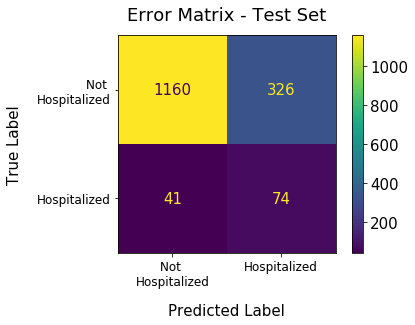

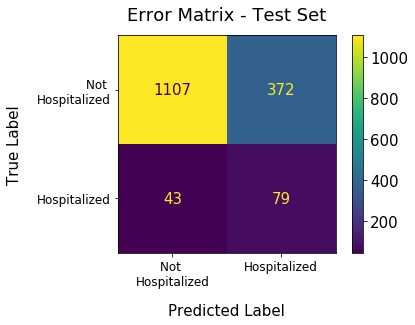

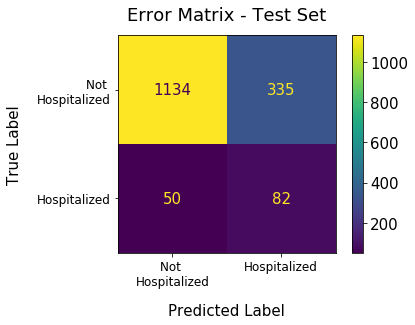

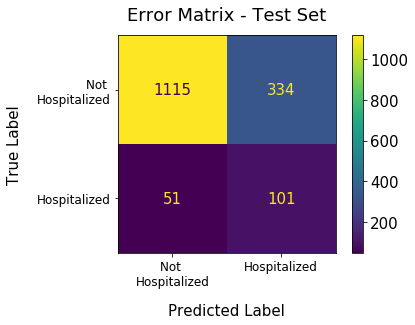

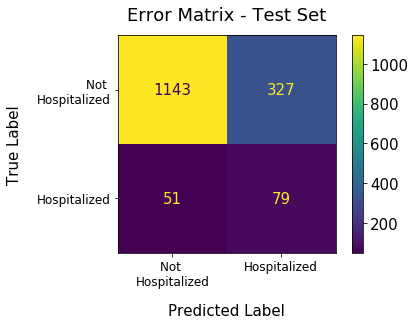

In [47]:
# recall and precision best yet - precision up to threshold!

ut.k_fold_validator(X_training, y_training, logreg)


### Model 26: Complement Naive Bayes with unknown prescription diagnosis data

Classifier: ComplementNB()
Cross-validation folds: 5


Train mean recall: 0.55 +/- 0.01
Train mean precision: 0.23 +/- 0.01
Train mean ROC-AUC: 0.69 +/- 0.01


Test mean recall: 0.54 +/- 0.04
Test mean precision: 0.23 +/- 0.03
Test mean ROC-AUC: 0.69 +/- 0.02


Feature weights: 
                     weight  abs_weight
emphysema_binary   5.43040     5.43040
heart_fail_binary  4.97840     4.97840
chron_bronc_binary 4.82240     4.82240
taking_ins_binary  4.46240     4.46240
unknown_dx         4.35940     4.35940
ever_had_COPD      4.32500     4.32500
heart_cond_binary  3.58560     3.58560
num_rx             3.51640     3.51640
osteoarth_binary   3.39260     3.39260
asthma_binary      3.12170     3.12170
diabetes_binary    3.09570     3.09570
Other Hispanic     3.09170     3.09170
other_arth_binary  3.00680     3.00680
Non-Hispanic Asian 2.63010     2.63010
Mexican American   2.52650     2.52650
Non-Hispanic Black 2.10550     2.10550
Non-Hispanic White 1.76000     1.76000
RIDAGEYR         

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


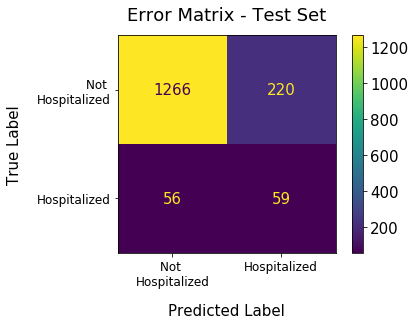

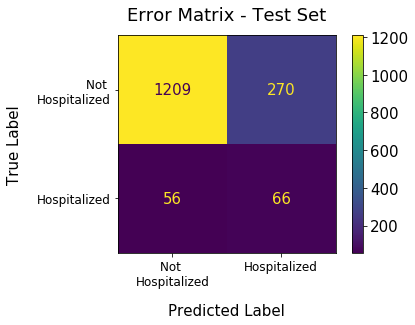

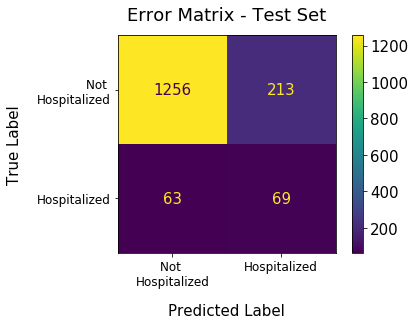

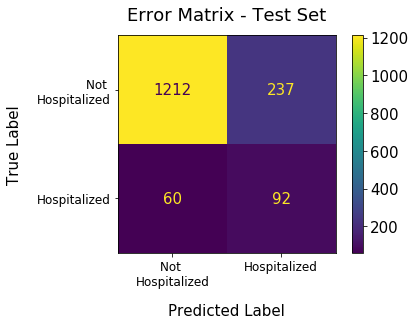

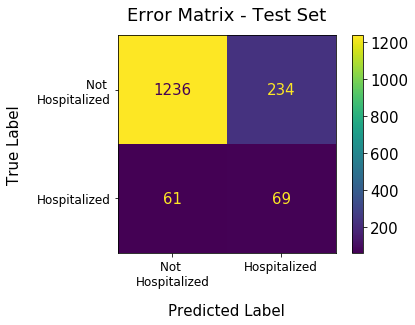

In [48]:
# recall up

ut.k_fold_validator(X_training, y_training, CompNB)


### Model 27: Random Forest with unknown prescription diagnosis data

Classifier: RandomForestClassifier(class_weight='balanced', max_depth=6,
                       min_samples_split=300)
Cross-validation folds: 5


Train mean recall: 0.69 +/- 0.01
Train mean precision: 0.19 +/- 0.01
Train mean ROC-AUC: 0.72 +/- 0.0


Test mean recall: 0.67 +/- 0.02
Test mean precision: 0.19 +/- 0.02
Test mean ROC-AUC: 0.71 +/- 0.01


Feature weights: 
                     weight  abs_weight
num_rx             0.28810     0.28810
RIDAGEYR           0.25000     0.25000
heart_cond_binary  0.14880     0.14880
osteoarth_binary   0.09120     0.09120
heart_fail_binary  0.04410     0.04410
diabetes_binary    0.03910     0.03910
other_arth_binary  0.03760     0.03760
ever_had_COPD      0.03110     0.03110
unknown_dx         0.02470     0.02470
Non-Hispanic Asian 0.00890     0.00890
Other Hispanic     0.00680     0.00680
asthma_binary      0.00610     0.00610
chron_bronc_binary 0.00570     0.00570
emphysema_binary   0.00490     0.00490
Non-Hispanic White 0.00440     0.00440
taki

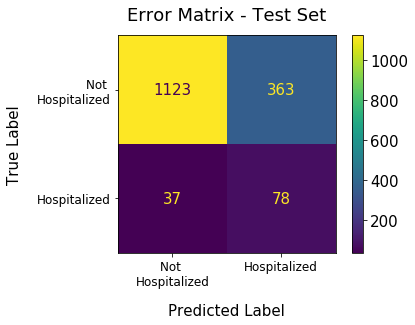

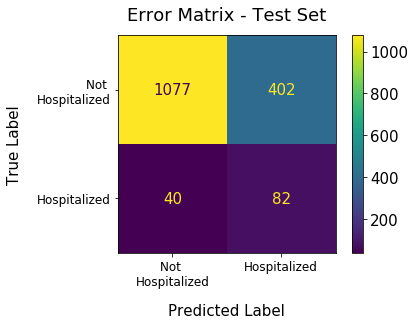

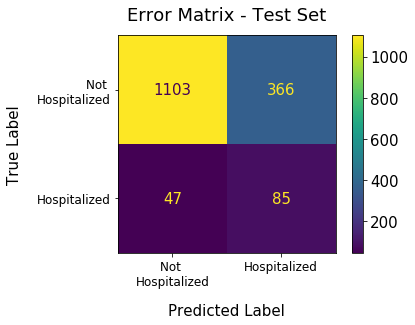

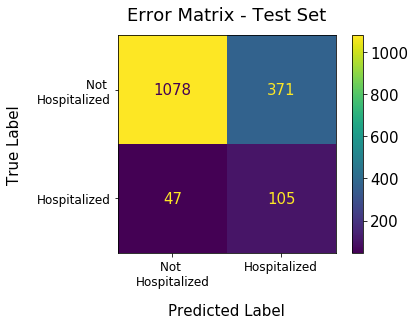

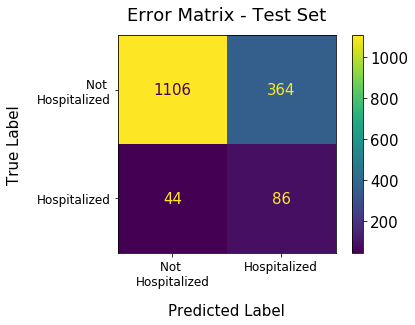

In [49]:
# recall up, precision still below threshold

ut.k_fold_validator(X_training, y_training, forest, cv=5)

### Model 28: Logistic regression with age buckets

In [50]:
# try age buckets instead of continuous age

binary_df_6 = pd.read_csv('data/binary_df_6').set_index('SEQN')
binary_df_6

osteoarth_binary  other_arth_binary  heart_fail_binary  \
SEQN                                                                   
93703.00000            0.00000            0.00000            0.00000   
93704.00000            0.00000            0.00000            0.00000   
93705.00000            0.00000            1.00000            0.00000   
93706.00000            0.00000            0.00000            0.00000   
93707.00000            0.00000            0.00000            0.00000   
...                        ...                ...                ...   
102952.00000           0.00000            0.00000            0.00000   
102953.00000           0.00000            0.00000            0.00000   
102954.00000           0.00000            0.00000            0.00000   
102955.00000           0.00000            0.00000            0.00000   
102956.00000           1.00000            0.00000            0.00000   

              heart_cond_binary  ever_had_COPD  emphysema_binary  \
SEQN                                                               
93703.00000             0.00000        0.00000           0.00000   
93704.00000             0.00000        0.00000           0.00000   
93705.00000             0.00000        0.00000           0.00000   
93706.00000             0.00000        0.00000           0.00000   
93707.00000             0.00000        0.00000           0.00000   
...                         ...            ...               ...   
102952.00000            0.00000        0.00000           0.00000   
102953.00000            0.00000        0.00000           0.00000   
102954.00000            0.00000        0.00000           0.00000   
102955.00000            0.00000        0.00000           0.00000   
102956.00000            0.00000        0.00000           0.00000   

              chron_bronc_binary  asthma_binary  diabetes_binary  \
SEQN                                                               
93703.00000              0.00000        0.00000          0.00000   
93704.00000              0.00000        0.00000          0.00000   
93705.00000              0.00000        0.00000          0.00000   
93706.00000              0.00000        0.00000          0.00000   
93707.00000              0.00000        0.00000          0.00000   
...                          ...            ...              ...   
102952.00000             0.00000        0.00000          0.00000   
102953.00000             0.00000        0.00000          0.00000   
102954.00000             0.00000        0.00000          0.00000   
102955.00000             0.00000        0.00000          0.00000   
102956.00000             0.00000        0.00000          0.00000   

              taking_ins_binary  updated_hosp  Mexican American  \
SEQN                                                              
93703.00000             0.00000       0.00000                 0   
93704.00000             0.00000       0.00000                 0   
93705.00000             0.00000       0.00000                 0   
93706.00000             0.00000       0.00000                 0   
93707.00000             0.00000       0.00000                 0   
...                         ...           ...               ...   
102952.00000            0.00000       0.00000                 0   
102953.00000            0.00000       0.00000                 1   
102954.00000            0.00000       0.00000                 0   
102955.00000            0.00000       0.00000                 0   
102956.00000            0.00000       0.00000                 0   

              Other Hispanic  Non-Hispanic White  Non-Hispanic Black  \
SEQN                                                                   
93703.00000                0                   0                   0   
93704.00000                0                   1                   0   
93705.00000                0                   0                   1   
93706.00000                0                   0                   0   
937

In [51]:
# define X and y

X = binary_df_6.drop(columns = ['updated_hosp'])
y = binary_df_6['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.1, random_state=807)


Classifier: LogisticRegression(class_weight='balanced')
Cross-validation folds: 5


Train mean recall: 0.65 +/- 0.01
Train mean precision: 0.21 +/- 0.01
Train mean ROC-AUC: 0.72 +/- 0.0


Test mean recall: 0.63 +/- 0.03
Test mean precision: 0.21 +/- 0.02
Test mean ROC-AUC: 0.71 +/- 0.01


Feature weights: 
                      weight  abs_weight
num_rx              1.77690     1.77690
age_70+             1.24830     1.24830
age_50-59           0.88940     0.88940
osteoarth_binary    0.83670     0.83670
heart_cond_binary   0.83300     0.83300
age_18-49           0.77550     0.77550
heart_fail_binary   0.76040     0.76040
unknown_dx          0.66560     0.66560
age_60-69           0.59970     0.59970
Non-Hispanic Asian -0.48420     0.48420
other_arth_binary   0.38760     0.38760
ever_had_COPD       0.36420     0.36420
emphysema_binary    0.29250     0.29250
age_0-5             0.25060     0.25060
Mexican American   -0.20330     0.20330
Non-Hispanic Black -0.16690     0.16690
Other Hispa

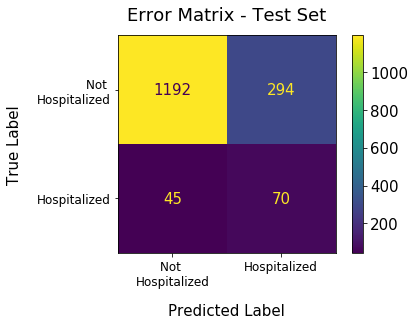

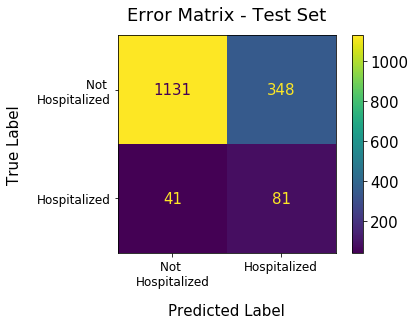

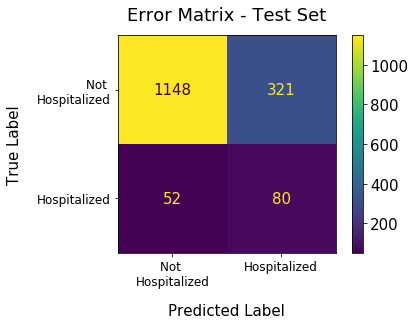

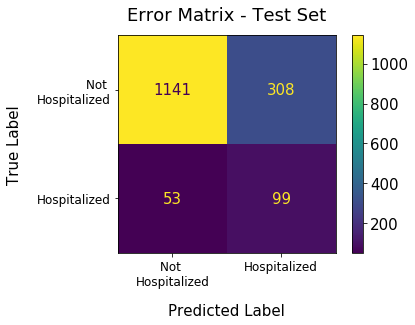

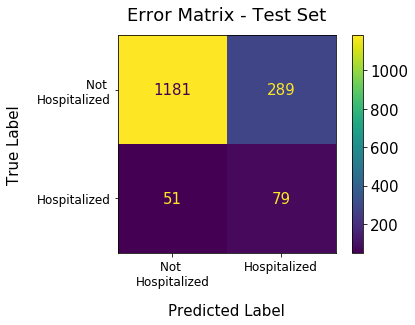

In [52]:
# recall slightly worse, precision slightly better
# race and age_buckets may not work well for logistic regression

ut.k_fold_validator(X_training, y_training, logreg)

### Model 29: Complement Naive Bayes with age buckets

Classifier: ComplementNB()
Cross-validation folds: 5


Train mean recall: 0.61 +/- 0.01
Train mean precision: 0.22 +/- 0.01
Train mean ROC-AUC: 0.71 +/- 0.0


Test mean recall: 0.6 +/- 0.05
Test mean precision: 0.22 +/- 0.03
Test mean ROC-AUC: 0.7 +/- 0.02


Feature weights: 
                     weight  abs_weight
emphysema_binary   5.59410     5.59410
heart_fail_binary  5.14210     5.14210
chron_bronc_binary 4.98610     4.98610
taking_ins_binary  4.62610     4.62610
unknown_dx         4.52310     4.52310
ever_had_COPD      4.48870     4.48870
heart_cond_binary  3.74940     3.74940
num_rx             3.68020     3.68020
osteoarth_binary   3.55640     3.55640
asthma_binary      3.28540     3.28540
diabetes_binary    3.25940     3.25940
Other Hispanic     3.25550     3.25550
other_arth_binary  3.17060     3.17060
age_50-59          3.12120     3.12120
age_0-5            3.11430     3.11430
age_70+            3.11430     3.11430
age_60-69          2.91370     2.91370
Non-Hispanic Asian 2

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


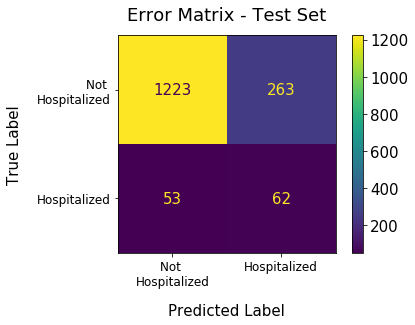

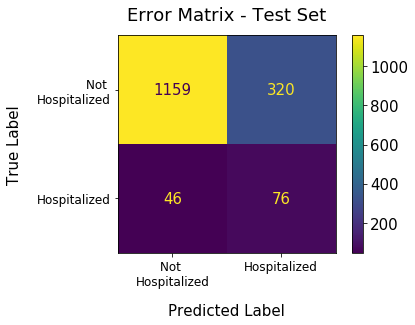

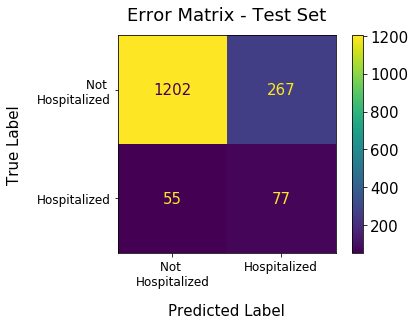

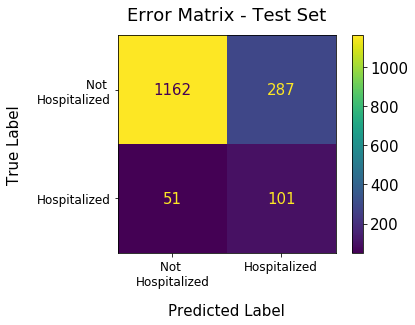

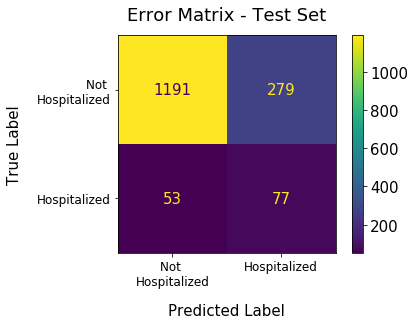

In [53]:
# recall way up

ut.k_fold_validator(X_training, y_training, CompNB)

### Model 30: Random Forest with age buckets

Classifier: RandomForestClassifier(class_weight='balanced', max_depth=6,
                       min_samples_split=300)
Cross-validation folds: 5


Train mean recall: 0.69 +/- 0.01
Train mean precision: 0.19 +/- 0.01
Train mean ROC-AUC: 0.72 +/- 0.0


Test mean recall: 0.67 +/- 0.03
Test mean precision: 0.19 +/- 0.02
Test mean ROC-AUC: 0.71 +/- 0.01


Feature weights: 
                     weight  abs_weight
num_rx             0.29060     0.29060
heart_cond_binary  0.14830     0.14830
age_70+            0.14120     0.14120
osteoarth_binary   0.11940     0.11940
heart_fail_binary  0.05180     0.05180
ever_had_COPD      0.05020     0.05020
diabetes_binary    0.04410     0.04410
other_arth_binary  0.03410     0.03410
unknown_dx         0.03370     0.03370
age_50-59          0.01310     0.01310
age_60-69          0.01190     0.01190
emphysema_binary   0.00840     0.00840
taking_ins_binary  0.00800     0.00800
age_0-5            0.00790     0.00790
age_18-49          0.00720     0.00720
chro

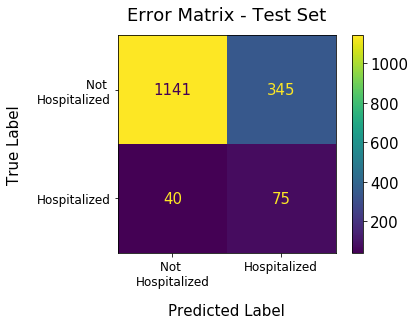

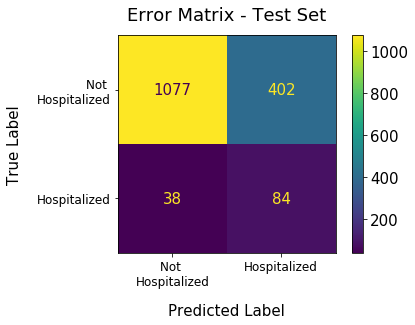

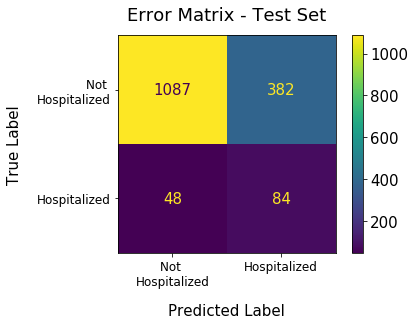

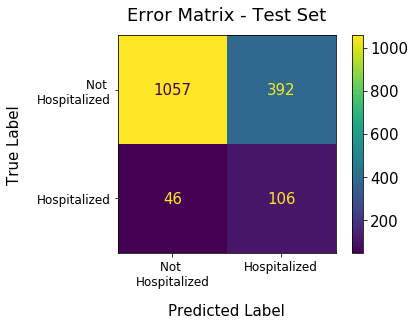

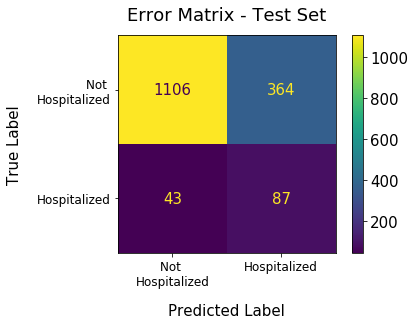

In [54]:
# recall slightly down, precision steady

ut.k_fold_validator(X_training, y_training, forest, cv=5)

### Model 31: Logistic regression with liver condition

In [55]:
# add feature for current liver condition

binary_df_7 = pd.read_csv('data/binary_df_7').set_index('SEQN')
binary_df_7

osteoarth_binary  other_arth_binary  heart_fail_binary  \
SEQN                                                                   
93703.00000            0.00000            0.00000            0.00000   
93704.00000            0.00000            0.00000            0.00000   
93705.00000            0.00000            1.00000            0.00000   
93706.00000            0.00000            0.00000            0.00000   
93707.00000            0.00000            0.00000            0.00000   
...                        ...                ...                ...   
102952.00000           0.00000            0.00000            0.00000   
102953.00000           0.00000            0.00000            0.00000   
102954.00000           0.00000            0.00000            0.00000   
102955.00000           0.00000            0.00000            0.00000   
102956.00000           1.00000            0.00000            0.00000   

              heart_cond_binary  ever_had_COPD  emphysema_binary  \
SEQN                                                               
93703.00000             0.00000        0.00000           0.00000   
93704.00000             0.00000        0.00000           0.00000   
93705.00000             0.00000        0.00000           0.00000   
93706.00000             0.00000        0.00000           0.00000   
93707.00000             0.00000        0.00000           0.00000   
...                         ...            ...               ...   
102952.00000            0.00000        0.00000           0.00000   
102953.00000            0.00000        0.00000           0.00000   
102954.00000            0.00000        0.00000           0.00000   
102955.00000            0.00000        0.00000           0.00000   
102956.00000            0.00000        0.00000           0.00000   

              chron_bronc_binary  asthma_binary  diabetes_binary  \
SEQN                                                               
93703.00000              0.00000        0.00000          0.00000   
93704.00000              0.00000        0.00000          0.00000   
93705.00000              0.00000        0.00000          0.00000   
93706.00000              0.00000        0.00000          0.00000   
93707.00000              0.00000        0.00000          0.00000   
...                          ...            ...              ...   
102952.00000             0.00000        0.00000          0.00000   
102953.00000             0.00000        0.00000          0.00000   
102954.00000             0.00000        0.00000          0.00000   
102955.00000             0.00000        0.00000          0.00000   
102956.00000             0.00000        0.00000          0.00000   

              taking_ins_binary  updated_hosp  Mexican American  \
SEQN                                                              
93703.00000             0.00000       0.00000                 0   
93704.00000             0.00000       0.00000                 0   
93705.00000             0.00000       0.00000                 0   
93706.00000             0.00000       0.00000                 0   
93707.00000             0.00000       0.00000                 0   
...                         ...           ...               ...   
102952.00000            0.00000       0.00000                 0   
102953.00000            0.00000       0.00000                 1   
102954.00000            0.00000       0.00000                 0   
102955.00000            0.00000       0.00000                 0   
102956.00000            0.00000       0.00000                 0   

              Other Hispanic  Non-Hispanic White  Non-Hispanic Black  \
SEQN                                                                   
93703.00000                0                   0                   0   
93704.00000                0                   1                   0   
93705.00000                0                   0                   1   
93706.00000                0                   0                   0   
937

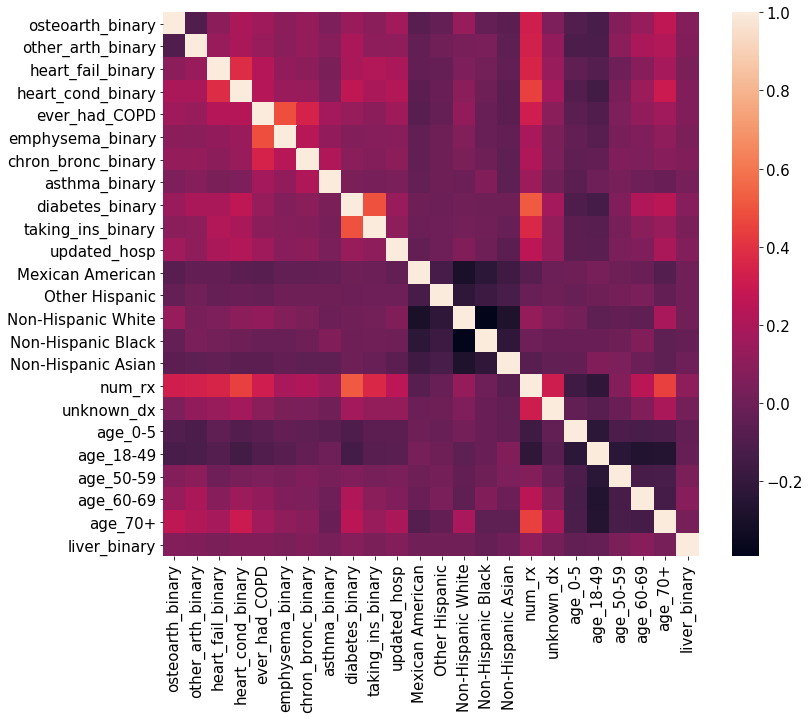

In [56]:
# recheck feature correlations since new features have been added

corr = binary_df_7.corr()

plt.figure(figsize = (12,10))
sns.heatmap(corr)

# number of rx is correlated with lots of conditions, but not more than 50%
# COPD and emphysema correlated about 50%

In [57]:
# define X and y

X = binary_df_7.drop(columns = ['updated_hosp'])
y = binary_df_7['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.1, random_state=807)



Classifier: LogisticRegression(class_weight='balanced')
Cross-validation folds: 5


Train mean recall: 0.65 +/- 0.01
Train mean precision: 0.21 +/- 0.01
Train mean ROC-AUC: 0.72 +/- 0.0


Test mean recall: 0.63 +/- 0.02
Test mean precision: 0.21 +/- 0.02
Test mean ROC-AUC: 0.71 +/- 0.01


Feature weights: 
                      weight  abs_weight
num_rx              1.77060     1.77060
age_70+             1.24870     1.24870
age_50-59           0.88970     0.88970
osteoarth_binary    0.83180     0.83180
heart_cond_binary   0.83090     0.83090
age_18-49           0.77450     0.77450
heart_fail_binary   0.76030     0.76030
unknown_dx          0.66560     0.66560
age_60-69           0.59790     0.59790
Non-Hispanic Asian -0.48740     0.48740
other_arth_binary   0.38760     0.38760
ever_had_COPD       0.36490     0.36490
emphysema_binary    0.29440     0.29440
age_0-5             0.25030     0.25030
Mexican American   -0.20520     0.20520
Non-Hispanic Black -0.16770     0.16770
Other Hispa

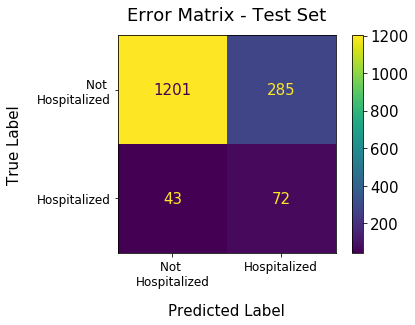

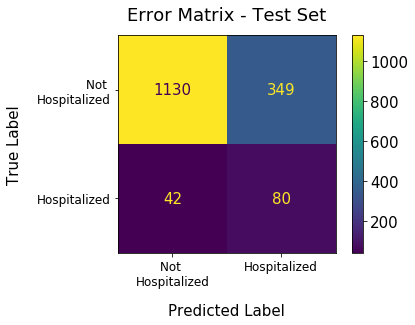

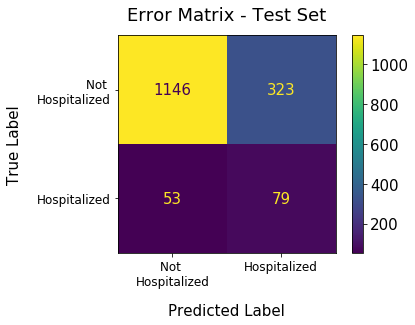

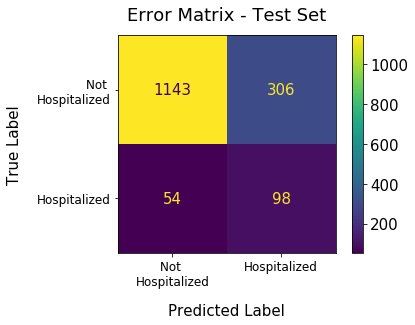

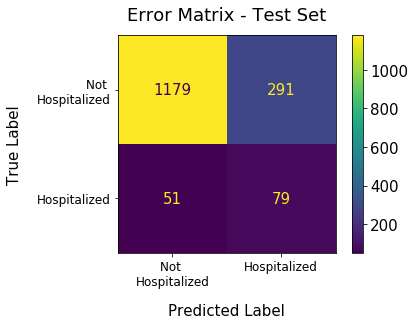

In [58]:
# no change from previous logistic regression model

logreg = LogisticRegression(class_weight='balanced')

ut.k_fold_validator(X_training, y_training, logreg)

### Model 32: Complement Naive Bayes with Liver Condition

Classifier: ComplementNB()
Cross-validation folds: 5


Train mean recall: 0.61 +/- 0.01
Train mean precision: 0.22 +/- 0.01
Train mean ROC-AUC: 0.71 +/- 0.01


Test mean recall: 0.6 +/- 0.04
Test mean precision: 0.21 +/- 0.03
Test mean ROC-AUC: 0.7 +/- 0.02


Feature weights: 
                     weight  abs_weight
emphysema_binary   5.59970     5.59970
liver_binary       5.18750     5.18750
heart_fail_binary  5.14770     5.14770
chron_bronc_binary 4.99170     4.99170
taking_ins_binary  4.63170     4.63170
unknown_dx         4.52870     4.52870
ever_had_COPD      4.49430     4.49430
heart_cond_binary  3.75500     3.75500
num_rx             3.68580     3.68580
osteoarth_binary   3.56200     3.56200
asthma_binary      3.29100     3.29100
diabetes_binary    3.26500     3.26500
Other Hispanic     3.26110     3.26110
other_arth_binary  3.17620     3.17620
age_50-59          3.12680     3.12680
age_0-5            3.11990     3.11990
age_70+            3.11990     3.11990
age_60-69          

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


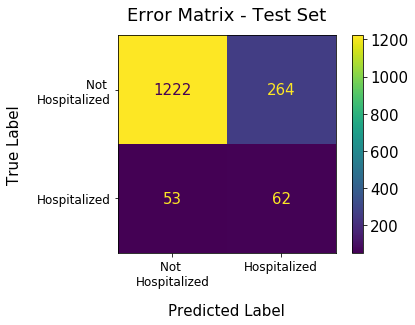

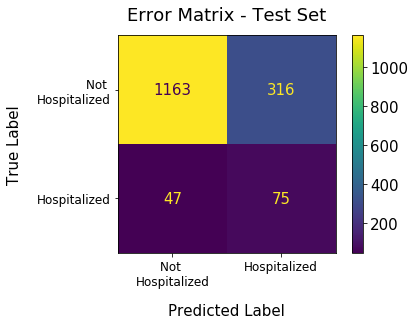

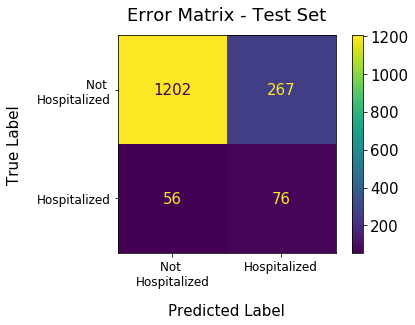

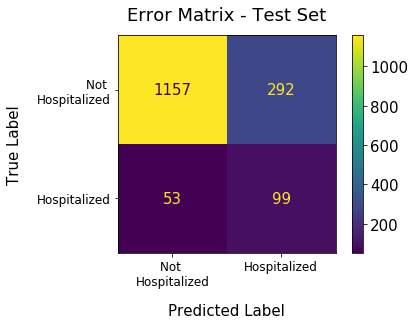

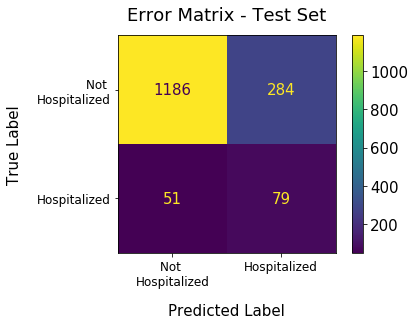

In [59]:
# recall steady, precision slightly down

CompNB = ComplementNB()

ut.k_fold_validator(X_training, y_training, CompNB)

### Model 33: Random Forest with Liver Condition

Classifier: RandomForestClassifier(class_weight='balanced', max_depth=6,
                       min_samples_split=300)
Cross-validation folds: 5


Train mean recall: 0.69 +/- 0.01
Train mean precision: 0.2 +/- 0.01
Train mean ROC-AUC: 0.72 +/- 0.0


Test mean recall: 0.67 +/- 0.02
Test mean precision: 0.19 +/- 0.01
Test mean ROC-AUC: 0.71 +/- 0.01


Feature weights: 
                     weight  abs_weight
num_rx             0.27810     0.27810
heart_cond_binary  0.17730     0.17730
age_70+            0.15600     0.15600
osteoarth_binary   0.11250     0.11250
heart_fail_binary  0.05240     0.05240
diabetes_binary    0.04080     0.04080
other_arth_binary  0.04040     0.04040
unknown_dx         0.03900     0.03900
ever_had_COPD      0.02590     0.02590
Non-Hispanic Asian 0.00950     0.00950
taking_ins_binary  0.00920     0.00920
age_0-5            0.00870     0.00870
age_50-59          0.00850     0.00850
age_60-69          0.00710     0.00710
chron_bronc_binary 0.00600     0.00600
age_1

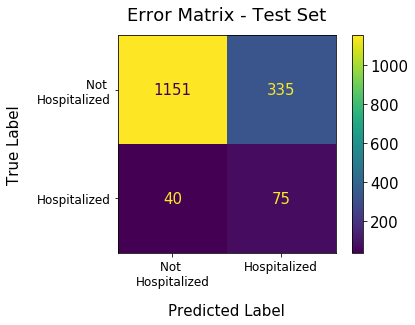

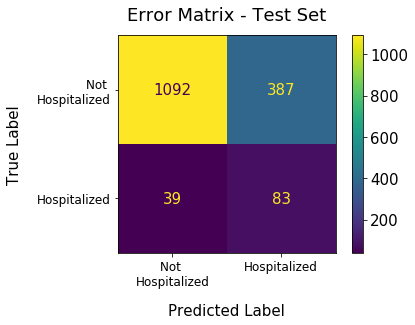

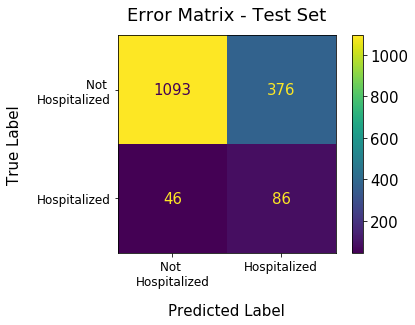

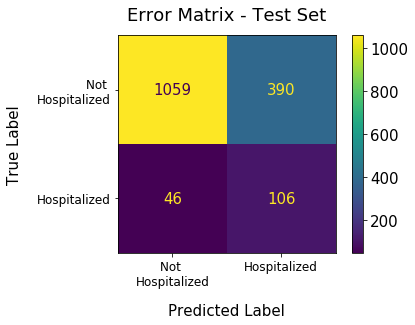

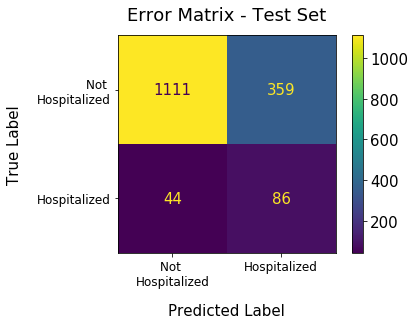

In [60]:
# recall up, precision steady

ut.k_fold_validator(X_training, y_training, forest, cv=5)

plt.savefig('images/final-forest', bbox_inches='tight')

In [61]:
# check how many ppl have current liver condition
binary_df_7['liver_binary'].value_counts()

# very few, but because it has a heavy weight/importance, let's keep it in for now

0    8760
1     134
Name: liver_binary, dtype: int64

### Model 34: Logistic Regression with cancer diagnoses

In [62]:
binary_df_8 = pd.read_csv('data/binary_df_8').set_index('SEQN')
binary_df_8.head()

osteoarth_binary  other_arth_binary  heart_fail_binary  \
SEQN                                                                  
93703.00000           0.00000            0.00000            0.00000   
93704.00000           0.00000            0.00000            0.00000   
93705.00000           0.00000            1.00000            0.00000   
93706.00000           0.00000            0.00000            0.00000   
93707.00000           0.00000            0.00000            0.00000   

             heart_cond_binary  ever_had_COPD  emphysema_binary  \
SEQN                                                              
93703.00000            0.00000        0.00000           0.00000   
93704.00000            0.00000        0.00000           0.00000   
93705.00000            0.00000        0.00000           0.00000   
93706.00000            0.00000        0.00000           0.00000   
93707.00000            0.00000        0.00000           0.00000   

             chron_bronc_binary  asthma_binary  diabetes_binary  \
SEQN                                                              
93703.00000             0.00000        0.00000          0.00000   
93704.00000             0.00000        0.00000          0.00000   
93705.00000             0.00000        0.00000          0.00000   
93706.00000             0.00000        0.00000          0.00000   
93707.00000             0.00000        0.00000          0.00000   

             taking_ins_binary  updated_hosp  Mexican American  \
SEQN                                                             
93703.00000            0.00000       0.00000                 0   
93704.00000            0.00000       0.00000                 0   
93705.00000            0.00000       0.00000                 0   
93706.00000            0.00000       0.00000                 0   
93707.00000            0.00000       0.00000                 0   

             Other Hispanic  Non-Hispanic White  Non-Hispanic Black  \
SEQN                                                                  
93703.00000               0                   0                   0   
93704.00000               0                   1                   0   
93705.00000               0                   0                   1   
93706.00000               0                   0                   0   
93707.00000               0                   0                   0   

             Non-Hispanic Asian  num_rx  unknown_dx  age_0-5  age_18-49  \
SEQN                                                                      
93703.00000                   1 0.00000     0.00000        1          0   
93704.00000                   0 0.00000     0.00000        1          0   
93705.00000                   0 2.00000     0.00000        0          0   
93706.00000                   1 0.00000     0.00000        0          1   
93707.00000                   0 0.00000     0.00000        0          0   

             age_50-59  age_60-69  age_70+  liver_binary  recent_cancer  
SEQN                                                                     
93703.00000          0          0        0             0              0  
93704.00000          0          0        0             0              0  
93705.00000          0          1        0             0              0  
93706.00000          0          0        0             0              0  
93707.00000          0          0        0             0              0

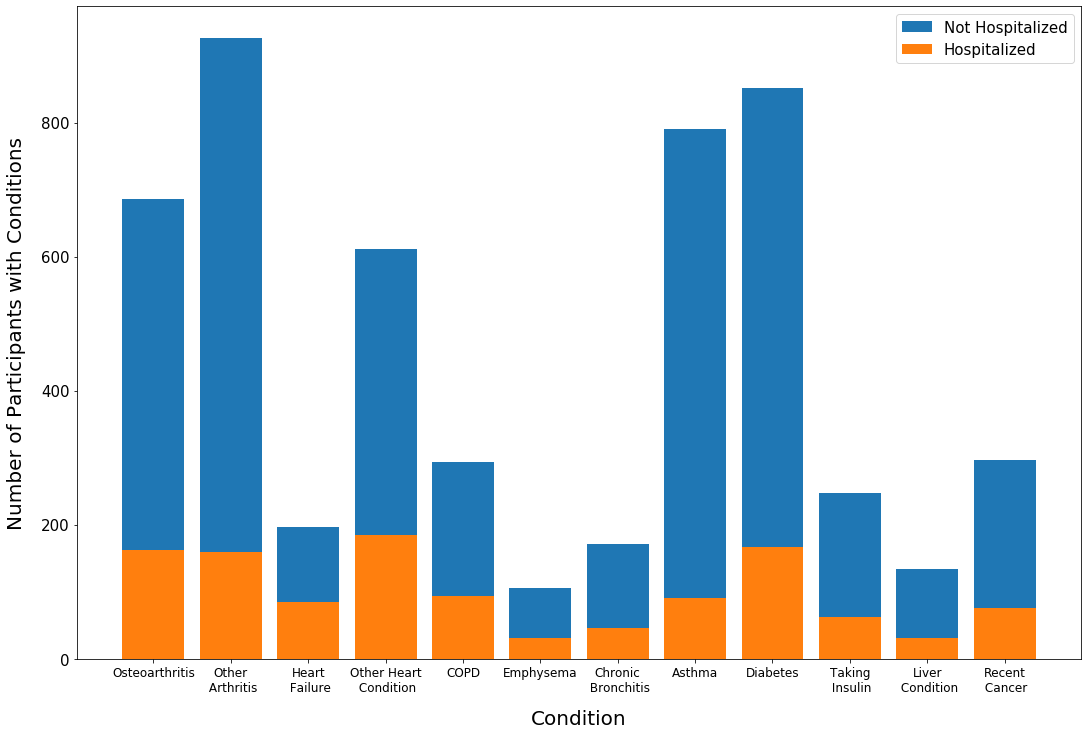

In [63]:
# plot bar chart to showcase odds ratios of variables and hospitalization

fig, ax = plt.subplots(figsize=(18,12))

# create list of columns to plot
col_list = list(binary_df_8.columns)[:10] + list(binary_df_8.columns)[23:]

# create lists for number of people with each condition who were and were not hospitalized
yes_list = []
no_list = []

for col in col_list:
    yes = binary_df_8.loc[(binary_df_8[col] == 1) & (binary_df_2['updated_hosp'] == 1), 'updated_hosp'].count()
    no = binary_df_8.loc[(binary_df_8[col] == 1) & (binary_df_2['updated_hosp'] == 0), 'updated_hosp'].count()
    
    yes_list.append(yes)
    no_list.append(no)

ax.bar(x=col_list, height=no_list, label='Not Hospitalized', bottom=yes_list)
ax.bar(x=col_list, height=yes_list, label='Hospitalized')

# for tick in ax.get_xticklabels():
#     tick.set_rotation(90)

ax.set_xticklabels(['Osteoarthritis', 
                    'Other\n Arthritis', 
                    'Heart\n Failure', 
                    'Other Heart\n Condition', 
                    'COPD', 'Emphysema', 
                    'Chronic\n Bronchitis', 
                    'Asthma', 
                    'Diabetes', 
                    'Taking\n Insulin',
                   'Liver\n Condition',
                   'Recent\n Cancer'],
                  fontsize=12)

ax.set_xlabel('Condition', fontsize=20, labelpad=15)
ax.set_ylabel('Number of Participants with Conditions', fontsize=20, labelpad=15)

ax.legend(fontsize=15)

In [73]:
# calculate odds ratios

odds_list = []

for col in col_list:
    a = binary_df_8.loc[(binary_df_8[col] == 1) & (binary_df_8['updated_hosp'] == 1), 'updated_hosp'].count()
    b = binary_df_8.loc[(binary_df_8[col] == 1) & (binary_df_8['updated_hosp'] == 0), 'updated_hosp'].count()
    c = binary_df_8.loc[(binary_df_8[col] == 0) & (binary_df_8['updated_hosp'] == 1), 'updated_hosp'].count()
    d = binary_df_8.loc[(binary_df_8[col] == 0) & (binary_df_8['updated_hosp'] == 0), 'updated_hosp'].count()
    
    odds_ratio = round((a/c) / (b/d), 2)
    
    odds_list.append(odds_ratio)

    print(col, odds_ratio)

osteoarth_binary 4.32
other_arth_binary 2.76
heart_fail_binary 9.81
heart_cond_binary 6.35
ever_had_COPD 5.97
emphysema_binary 4.96
chron_bronc_binary 4.43
asthma_binary 1.56
diabetes_binary 3.34
taking_ins_binary 4.1
liver_binary 3.55
recent_cancer 4.3


In [79]:
odds_df = pd.DataFrame({'Condition' : col_list, 'Odds_Ratio' : odds_list})
odds_df.sort_values('Odds_Ratio', ascending=False, inplace=True)
odds_df

Condition  Odds_Ratio
2    heart_fail_binary     9.81000
3    heart_cond_binary     6.35000
4        ever_had_COPD     5.97000
5     emphysema_binary     4.96000
6   chron_bronc_binary     4.43000
0     osteoarth_binary     4.32000
11       recent_cancer     4.30000
9    taking_ins_binary     4.10000
10        liver_binary     3.55000
8      diabetes_binary     3.34000
1    other_arth_binary     2.76000
7        asthma_binary     1.56000

In [65]:
# try adding recent cancer dx

X = binary_df_8.drop(columns = ['updated_hosp'])
y = binary_df_8['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.1, random_state=807)



Classifier: LogisticRegression(class_weight='balanced')
Cross-validation folds: 5


Train mean recall: 0.65 +/- 0.01
Train mean precision: 0.21 +/- 0.01
Train mean ROC-AUC: 0.72 +/- 0.0


Test mean recall: 0.64 +/- 0.02
Test mean precision: 0.21 +/- 0.02
Test mean ROC-AUC: 0.71 +/- 0.01


Feature weights: 
                      weight  abs_weight
num_rx              1.71800     1.71800
age_70+             1.18570     1.18570
age_50-59           0.86320     0.86320
osteoarth_binary    0.85310     0.85310
heart_cond_binary   0.82380     0.82380
heart_fail_binary   0.77500     0.77500
age_18-49           0.76450     0.76450
unknown_dx          0.66960     0.66960
age_60-69           0.56090     0.56090
recent_cancer       0.51150     0.51150
Non-Hispanic Asian -0.47450     0.47450
other_arth_binary   0.37750     0.37750
ever_had_COPD       0.36100     0.36100
emphysema_binary    0.27640     0.27640
age_0-5             0.25180     0.25180
Mexican American   -0.19770     0.19770
Other Hispa

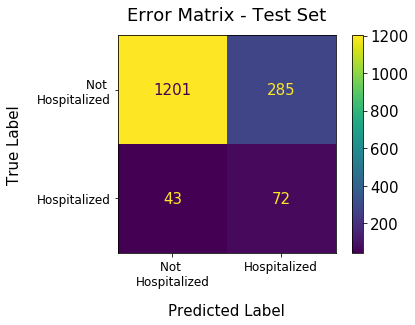

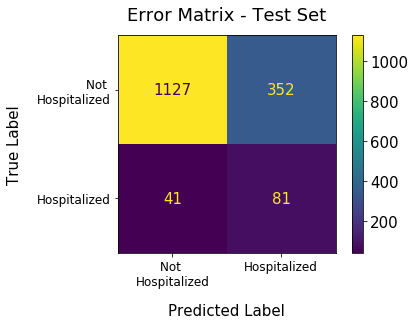

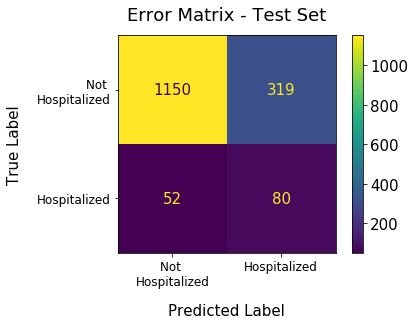

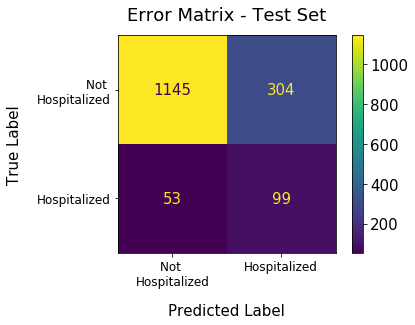

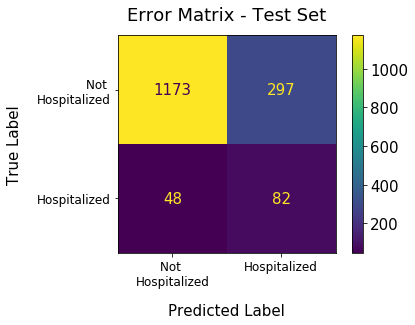

In [66]:
# recall slightly up from previous model

ut.k_fold_validator(X_training, y_training, logreg)

plt.savefig('images/final-logreg', bbox_inches='tight')

Classifier: LogisticRegression(class_weight='balanced')
Cross-validation folds: 5


Train mean recall: 0.64 +/- 0.0
Train mean precision: 0.21 +/- 0.01
Train mean ROC-AUC: 0.72 +/- 0.0


Test mean recall: 0.63 +/- 0.02
Test mean precision: 0.21 +/- 0.02
Test mean ROC-AUC: 0.71 +/- 0.01


Feature weights: 
                      weight  abs_weight
num_rx              1.72390     1.72390
age_70+             1.10290     1.10290
osteoarth_binary    0.86120     0.86120
heart_cond_binary   0.82110     0.82110
age_50-59           0.77490     0.77490
heart_fail_binary   0.77200     0.77200
age_18-49           0.68360     0.68360
unknown_dx          0.67110     0.67110
recent_cancer       0.51280     0.51280
age_60-69           0.47400     0.47400
other_arth_binary   0.37880     0.37880
Non-Hispanic Asian -0.36600     0.36600
ever_had_COPD       0.35730     0.35730
emphysema_binary    0.28210     0.28210
Other Hispanic      0.27320     0.27320
chron_bronc_binary  0.14670     0.14670
diabetes_bin

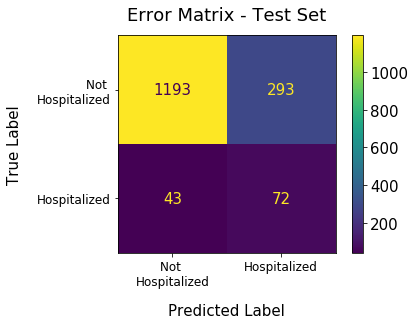

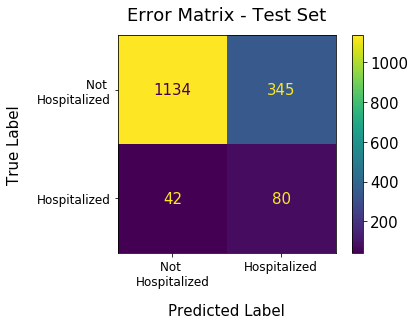

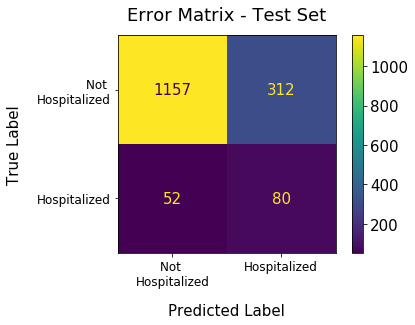

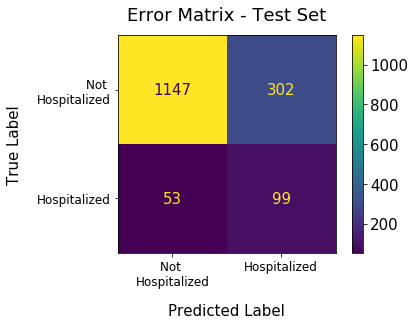

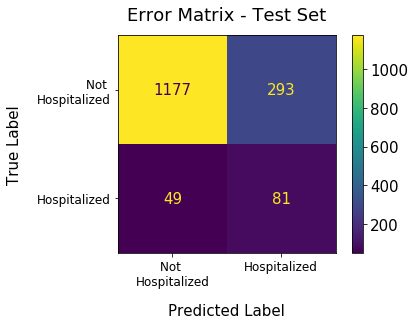

In [67]:
# try dropping age and race columns with lower weights
# slightly worse when dropped 'Non-Hispanic Black'

X = binary_df_8.drop(columns = ['updated_hosp', 'age_0-5',  'Non-Hispanic White', 'Non-Hispanic Black'])
y = binary_df_8['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.1, random_state=807)

ut.k_fold_validator(X_training, y_training, logreg)

### Model 35: Complement Naive Bayes with cancer diagnoses

Classifier: ComplementNB()
Cross-validation folds: 5


Train mean recall: 0.61 +/- 0.01
Train mean precision: 0.22 +/- 0.01
Train mean ROC-AUC: 0.71 +/- 0.0


Test mean recall: 0.6 +/- 0.05
Test mean precision: 0.21 +/- 0.03
Test mean ROC-AUC: 0.7 +/- 0.02


Feature weights: 
                     weight  abs_weight
emphysema_binary   5.61250     5.61250
liver_binary       5.20020     5.20020
heart_fail_binary  5.16050     5.16050
chron_bronc_binary 5.00450     5.00450
taking_ins_binary  4.64450     4.64450
unknown_dx         4.54140     4.54140
ever_had_COPD      4.50710     4.50710
recent_cancer      4.36850     4.36850
heart_cond_binary  3.76770     3.76770
num_rx             3.69850     3.69850
osteoarth_binary   3.57470     3.57470
asthma_binary      3.30380     3.30380
diabetes_binary    3.27780     3.27780
Other Hispanic     3.27380     3.27380
other_arth_binary  3.18890     3.18890
age_50-59          3.13950     3.13950
age_0-5            3.13270     3.13270
age_70+            3

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


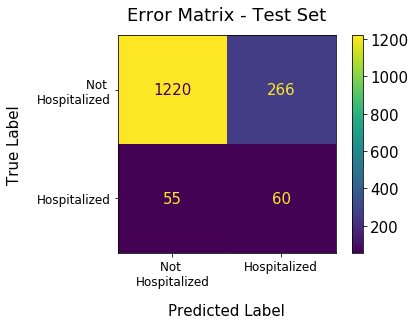

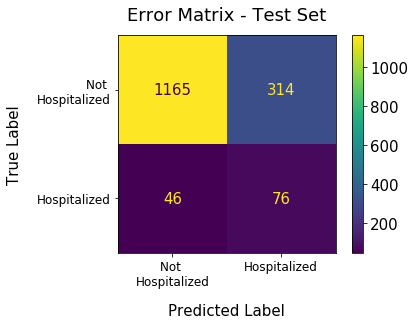

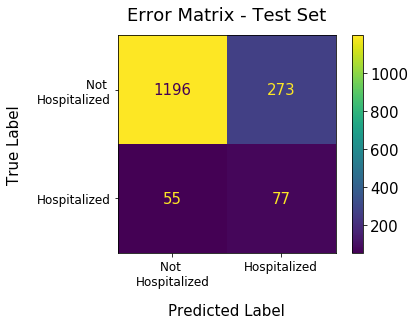

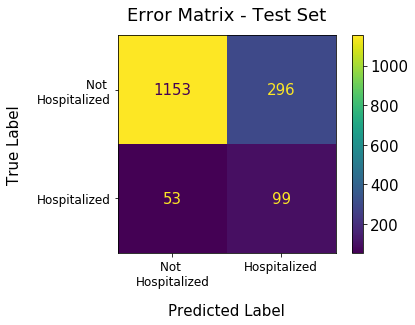

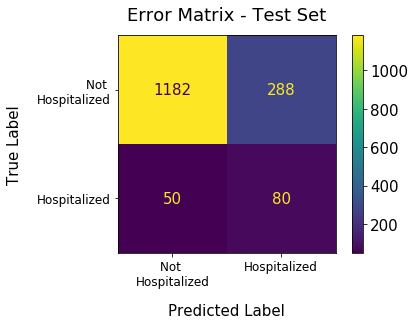

In [68]:
# recall slightly worse than 2 models ago

X = binary_df_8.drop(columns = ['updated_hosp'])
y = binary_df_8['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.1, random_state=807)

ut.k_fold_validator(X_training, y_training, CompNB)

### Model 36: Random forest with cancer diagnoses

Classifier: RandomForestClassifier(class_weight='balanced', max_depth=6,
                       min_samples_split=300)
Cross-validation folds: 5


Train mean recall: 0.69 +/- 0.01
Train mean precision: 0.19 +/- 0.01
Train mean ROC-AUC: 0.72 +/- 0.0


Test mean recall: 0.68 +/- 0.02
Test mean precision: 0.19 +/- 0.02
Test mean ROC-AUC: 0.71 +/- 0.01


Feature weights: 
                     weight  abs_weight
num_rx             0.32220     0.32220
age_70+            0.16210     0.16210
heart_cond_binary  0.13010     0.13010
osteoarth_binary   0.09020     0.09020
ever_had_COPD      0.05050     0.05050
diabetes_binary    0.04590     0.04590
heart_fail_binary  0.03920     0.03920
unknown_dx         0.03590     0.03590
other_arth_binary  0.03400     0.03400
age_0-5            0.01370     0.01370
recent_cancer      0.01100     0.01100
age_50-59          0.01030     0.01030
age_60-69          0.00800     0.00800
Non-Hispanic Asian 0.00760     0.00760
taking_ins_binary  0.00720     0.00720
chro

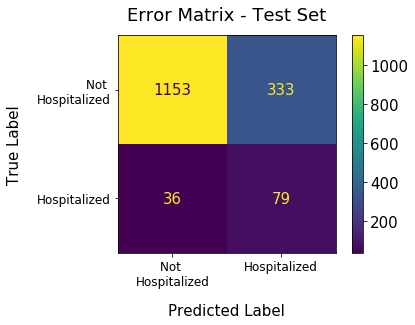

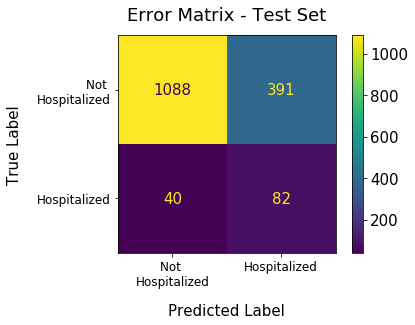

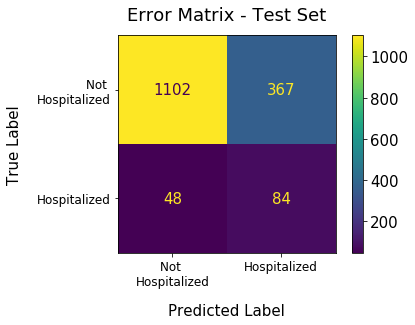

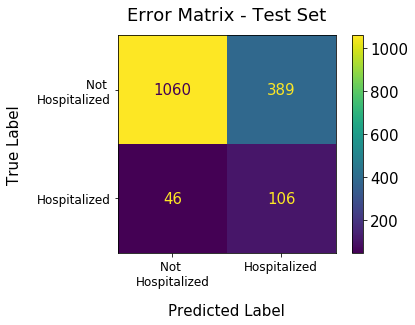

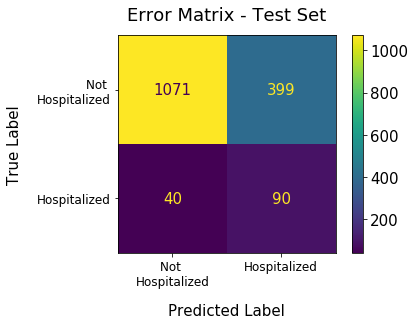

In [69]:
# recall down, precision steady

ut.k_fold_validator(X_training, y_training, forest, cv=5)

### Model 37: Adaptive boosted trees with cancer diagnoses

Classifier: AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         criterion='entropy',
                                                         max_depth=2,
                                                         max_features=7,
                                                         max_leaf_nodes=25,
                                                         min_samples_leaf=200,
                                                         min_samples_split=1000),
                   n_estimators=100)
Cross-validation folds: 5


Train mean recall: 0.67 +/- 0.01
Train mean precision: 0.2 +/- 0.01
Train mean ROC-AUC: 0.72 +/- 0.0


Test mean recall: 0.64 +/- 0.04
Test mean precision: 0.2 +/- 0.02
Test mean ROC-AUC: 0.71 +/- 0.01




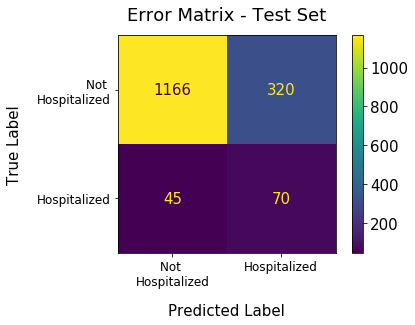

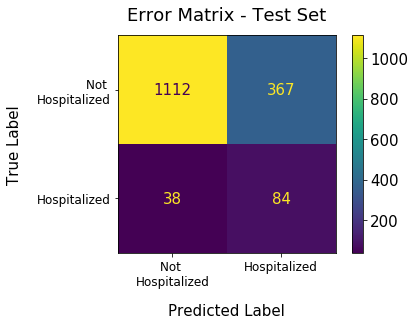

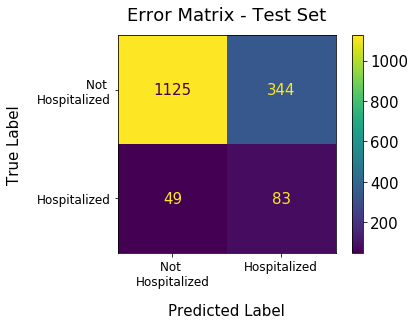

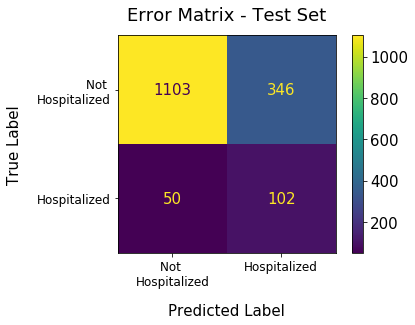

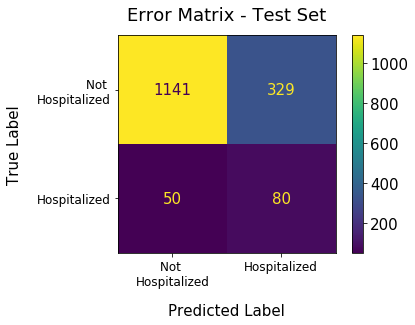

In [70]:
# recall worse than random forest, same as logistic regression

Ada = AdaBoostClassifier(base_estimator=tree, n_estimators=100)

ut.k_fold_validator(X_training, y_training, Ada)

## Test Final Model on Holdout Set

Train recall score: 0.65
Train precision score: 0.21
Train ROC-AUC score: 0.72


Holdout recall score: 0.69
Holdout precision score: 0.21
Holdout ROC-AUC score: 0.74




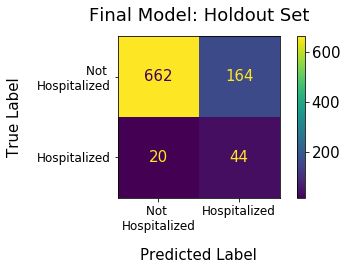

In [71]:
# chose Logistic Regression as final model since its recall score is better than Complement Naive Bayes
# and its precision score is above 0.2 threshold, which is not true for Random Forest
# recall score on holdout set is surprisingly high - 0.69
# when run on the holdout set, the results indicate overfitting, suggesting that such a high recall score may
# not be generalizable for all data - probably closer to 0.64 as in testing

logreg.fit(X_training, y_training)

y_pred_train = logreg.predict(X_training)
y_pred_holdout = logreg.predict(X_holdout)

print('Train recall score:', round(recall_score(y_training, y_pred_train), 2))
print('Train precision score:', round(precision_score(y_training, y_pred_train), 2)) 
print('Train ROC-AUC score:', round(roc_auc_score(y_training, y_pred_train), 2)) 
print('\n')
print('Holdout recall score:', round(recall_score(y_holdout, y_pred_holdout), 2))
print('Holdout precision score:', round(precision_score(y_holdout, y_pred_holdout), 2))  
print('Holdout ROC-AUC score:', round(roc_auc_score(y_holdout, y_pred_holdout), 2)) 
print('\n')

plot_confusion_matrix(logreg, X_holdout, y_holdout)
plt.title('Final Model: Holdout Set', fontsize=18, pad=15)
plt.xticks(ticks=(0,1), labels=['Not \nHospitalized', 'Hospitalized'], fontsize=12)
plt.yticks(ticks=(0,1), labels=['Not \nHospitalized', 'Hospitalized'], fontsize=12)
plt.xlabel('Predicted Label', labelpad=15)
plt.ylabel('True Label', labelpad=15)
plt.tight_layout()
plt.savefig('images/final-model-holdout', bbox_inches='tight')

In [72]:
# explore feature weights of final model

ut.order_features(logreg.coef_, X_training)

weight  abs_weight
age_70+             1.20580     1.20580
age_50-59           0.95550     0.95550
heart_cond_binary   0.75810     0.75810
osteoarth_binary    0.71450     0.71450
age_18-49           0.69000     0.69000
heart_fail_binary   0.68000     0.68000
unknown_dx          0.67490     0.67490
Non-Hispanic Asian -0.61930     0.61930
recent_cancer       0.60670     0.60670
age_60-69           0.59490     0.59490
liver_binary        0.45950     0.45950
ever_had_COPD       0.39090     0.39090
age_0-5             0.37390     0.37390
other_arth_binary   0.34530     0.34530
Mexican American   -0.22260     0.22260
chron_bronc_binary  0.21700     0.21700
diabetes_binary     0.17870     0.17870
emphysema_binary    0.16970     0.16970
Non-Hispanic Black -0.16460     0.16460
Non-Hispanic White -0.11470     0.11470
num_rx              0.08880     0.08880
asthma_binary       0.05670     0.05670
Other Hispanic      0.05230     0.05230
taking_ins_binary  -0.01560     0.01560

## Conclusions
Identifying hospitalized NHANES participants was a challenging problem since they comprised just 8.5% of all participants, and because some hospitalizations are due to random accidents rather than prior medical conditions. The final model provides value to ACOs by correctly predicting 69% of hospitalized patients, while keeping false positives (people whom the model predicted would be hospitalized but were not) to less than 80% of all predicted positives.

The model's precision score was 0.21, meaning that 21 out of every hundred participants returned by the model were truly hospitalized.  The model's 69% recall rate means that most hospitalized participants would be captured by the model. Since each avoided hospitalization is a win, ACOs seek to identify as many high-risk patients as possible.

The final model improved on the baseline model, which identified only 2% of hospitalized participants, though about 45% of the participants it flagged were truly hospitalized.

## Further Investigation
Although the Logistic Regression model had a better precision score than the Random Forest model, the Random Forest had a better recall score.  Its precision score did not quite meet the 0.2 threshold, but if it had, the Random Forest would have been the best performing model.  It is possible that with better hyperparameter tuning or more data, a Random Forest would perform better. 

It also seemed that the affect of age buckets rather than a continuous age variable was helpful to the Naive Bayes model but perhaps detrimental to the Logistic Regression and Random Forest models.  A next step would be to test the final model with an altered DataFrame containing a continuous age column.